## Table of Contents
<br>
<ol> 
    <h2><a href='#1' style="text-decoration : none; color: #000000;">1. Vulnerable/Control Set 30:70 </a><h2>
    <ul> <a href='#1.1' style="text-decoration : none; color: #000000;"> 1.1 Loading Data </a></ul>
    <ul> <a href='#1.2' style="text-decoration : none; color: #000000;"> 1.2  70: 30 Train Test split </a>
    <ol> <a href='#1.2.1' style="text-decoration : none; color: #000000;">1.2.1 Results </a></ol></ul>
    <ul> <a href='#1.3' style="text-decoration : none; color: #000000;"> 1.3  80: 20 Train Test split </a>
    <ol> <a href='#1.3.1' style="text-decoration : none; color: #000000;">1.3.1 Results </a></ol></ul>
    <h2><a href='#2' style="text-decoration : none; color: #000000;">2. Vulnerable/Control Set 50:50 </a><h2>
    <ul> <a href='#2.1' style="text-decoration : none; color: #000000;"> 2.1 Loading Data </a></ul>
    <ul> <a href='#2.2' style="text-decoration : none; color: #000000;"> 2.2  70: 30 Train Test split </a>
    <ol> <a href='#2.2.1' style="text-decoration : none; color: #000000;">2.2.1 Results </a></ol></ul>
    <ul> <a href='#2.3' style="text-decoration : none; color: #000000;"> 2.3  80: 20 Train Test split </a>
    <ol> <a href='#2.3.1' style="text-decoration : none; color: #000000;">2.3.1 Results </a></ol></ul>


<ol>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix as CM,accuracy_score,auc,roc_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,binarize
from pandas_ml import ConfusionMatrix

from IPython.display import display,clear_output,HTML

Using TensorFlow backend.


### <a id='1' style="text-decoration : none; color: #000000;"> 1 Vulnerable/Control 30:70 </a>

#### <a id='1.1' style="text-decoration : none; color: #000000;"> 1.1 Loading Data </a>

In [2]:
df=pd.read_csv('Final_feature_set.csv',index_col=['Unnamed: 0'])
df.fillna(value=0,inplace=True)
df=df[df['Age']>=0]
df.head()

df2=df.copy(deep=True)
df2.drop(['User_Id','User_Name_x','Created_At','Language'],axis=1,inplace=True)
df2.set_index(['User_Screen_Name'],inplace=True,drop=True)
df2.Gender=df2.Gender.apply(lambda x: 1 if x=='F' else 0)
df2=df2[df2['Avg Number of Mentions']!='True']

df2.head()

,Followers_Count,Friends_Count,Listed_Count,Favorites_Count,Statuses_Count,Number of Tweets,Avg Number of Mentions,Average Number of Links,Average Number of Words,Acc_Age_Month,Malicious,Age,Gender
User_Screen_Name,,,,,,,,,,,,,
MichaelDeMers4,12,42,0,11,120,113,1.3628318584070795,0.23008849557522126,9.610619469026547,67.746332,0,32.561429,0
vanbastarache,61,223,1,1507,648,611,0.33387888707037644,0.1833060556464812,13.734860883797054,84.591551,0,26.093862,1
leslievanilla,743,414,3,5216,789,229,0.6724890829694323,0.0611353711790393,4.973799126637554,27.153099,1,21.084834,1
EVJ44,187,270,3,8753,605,226,0.6327433628318584,0.584070796460177,10.336283185840708,19.283745,1,20.619374,1
Leah10123,20,253,0,106,141,138,0.5507246376811594,0.8840579710144928,7.195652173913044,81.419931,0,22.270800,1


In [3]:
print("The number of Vulnerable/Control Cases:")
df2.Malicious.value_counts()

The number of Vulnerable/Control Cases:


0    7185
1    2380
Name: Malicious, dtype: int64

In [4]:
nm=df2[df2['Malicious']==0]
m=df2[df2['Malicious']==1]

In [5]:
### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    display(cm)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy on test data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

#### <a id='1.2' style="text-decoration : none; color: #000000;"> 1.2  70: 30 Train Test split </a>

In [6]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [7]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 1.2.1 KNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,20,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4997     0     4997
True           0  1698     1698
__all__     4997  1698     6695

Accuracy of the  KNN  model for test data is: 0.8679442508710802

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2150    38     2188
True         341   341      682
__all__     2491   379     2870

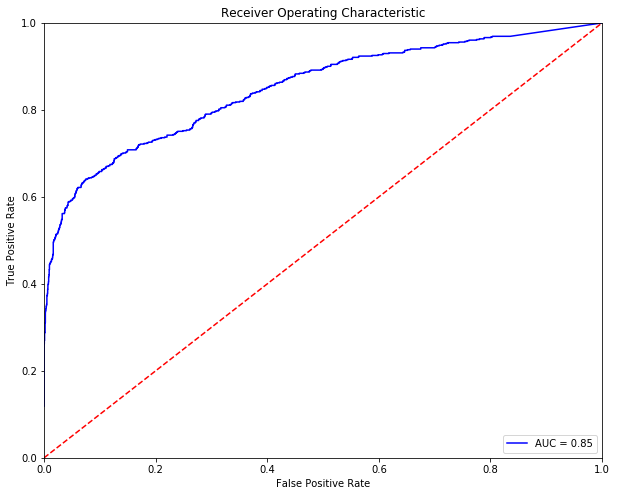

Optimal Threshold is 0.17071840700501725
Accuracy on test data is: 0.751567944250871


Predicted  False  True  __all__
Actual                         
False       1645   543     2188
True         170   512      682
__all__     1815  1055     2870

In [9]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [10]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.2 Logistic

In [11]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.5,False,True,0.5,10000,ovr,l2,newton-cg,1e-05


Accuracy of the  Logistic  model for the training data is: 0.8306198655713218

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4802   195     4997
True         939   759     1698
__all__     5741   954     6695

Accuracy of the  Logistic  model for test data is: 0.8337979094076655

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2098    90     2188
True         387   295      682
__all__     2485   385     2870

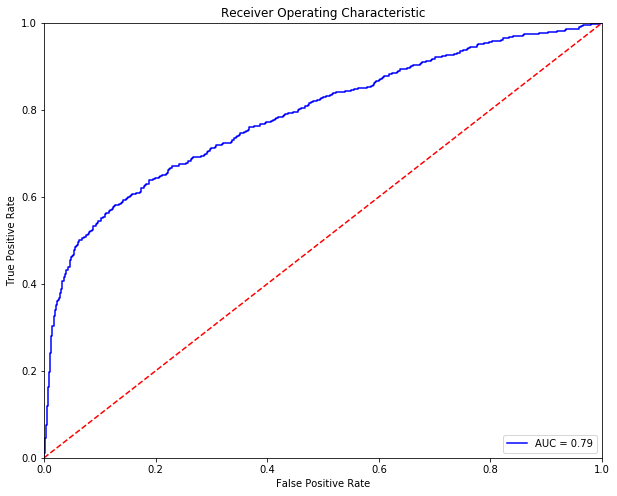

Optimal Threshold is 0.22737554079649955
Accuracy on test data is: 0.705226480836237


Predicted  False  True  __all__
Actual                         
False       1544   644     2188
True         202   480      682
__all__     1746  1124     2870

In [12]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [13]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.3 Random Forest Classifier

In [14]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,entropy,10,auto,10,0.1,10,10,0.1,500,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.8442120985810306

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4997     0     4997
True        1043   655     1698
__all__     6040   655     6695

Accuracy of the  Random Forest Trees  model for test data is: 0.8515679442508711

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2188     0     2188
True         426   256      682
__all__     2614   256     2870

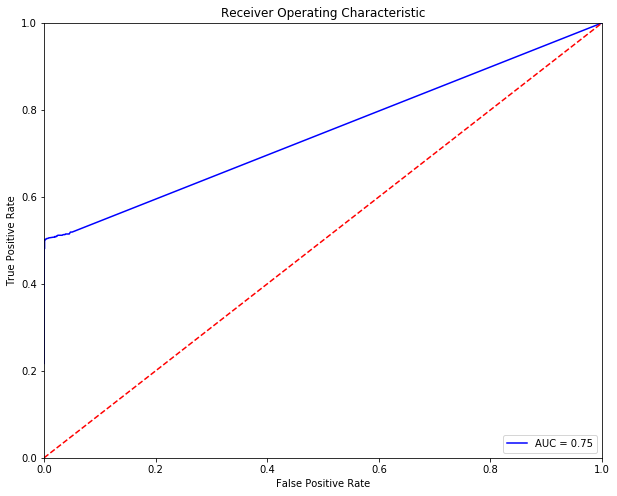

Optimal Threshold is 0.2003542737370254
Accuracy on test data is: 0.8498257839721254


Predicted  False  True  __all__
Actual                         
False       2085   103     2188
True         328   354      682
__all__     2413   457     2870

In [15]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [16]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

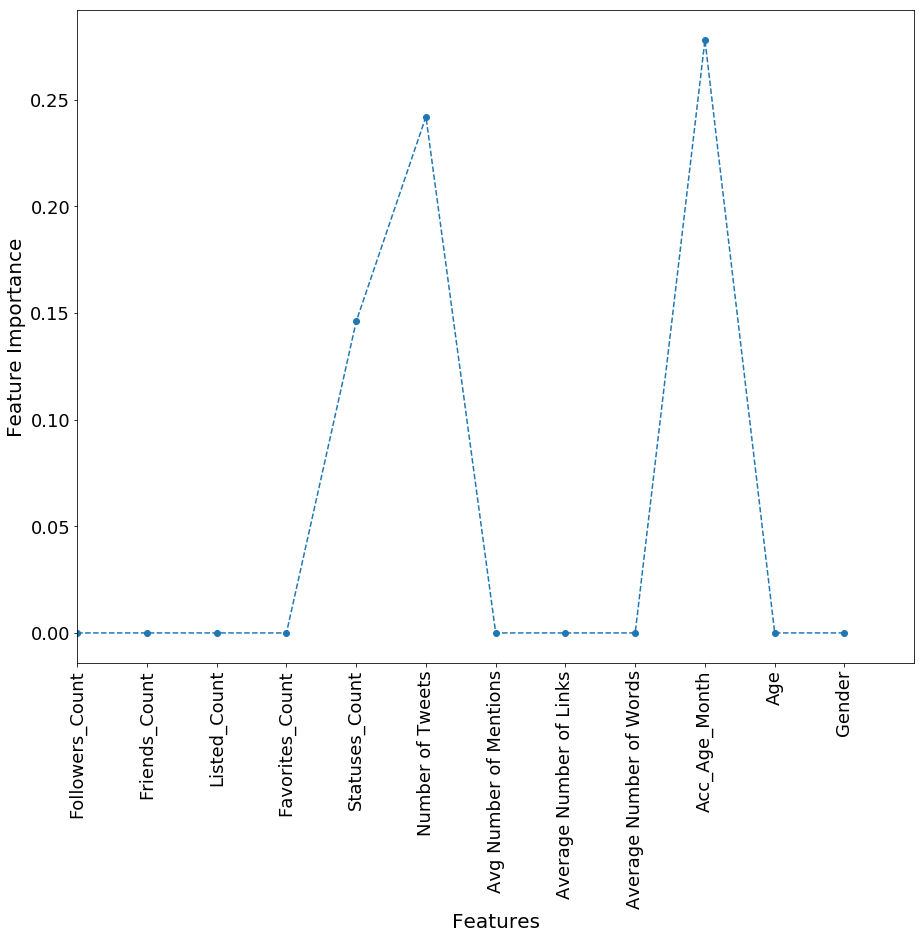

In [17]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 1.2.4 AdaBoost Classifier

In [18]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME.R,0.5,150,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.9061986557132188

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4916    81     4997
True         547  1151     1698
__all__     5463  1232     6695

Accuracy of the  AdaBoostClassifier  model for test data is: 0.8982578397212544

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2138    50     2188
True         242   440      682
__all__     2380   490     2870

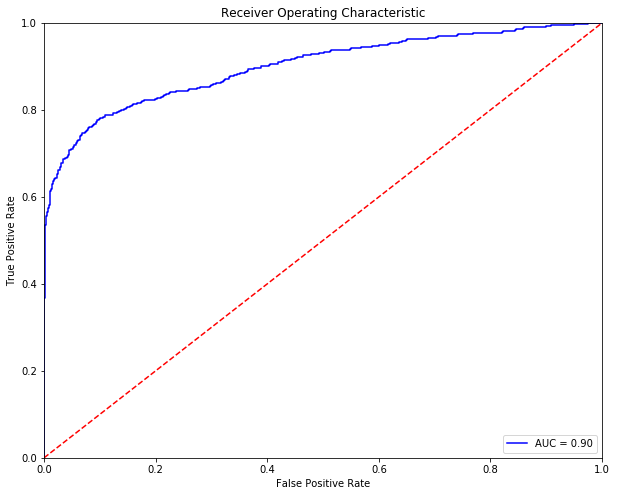

Optimal Threshold is 0.49440475648386956
Accuracy on test data is: 0.8219512195121951


Predicted  False  True  __all__
Actual                         
False       1799   389     2188
True         122   560      682
__all__     1921   949     2870

In [19]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [20]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

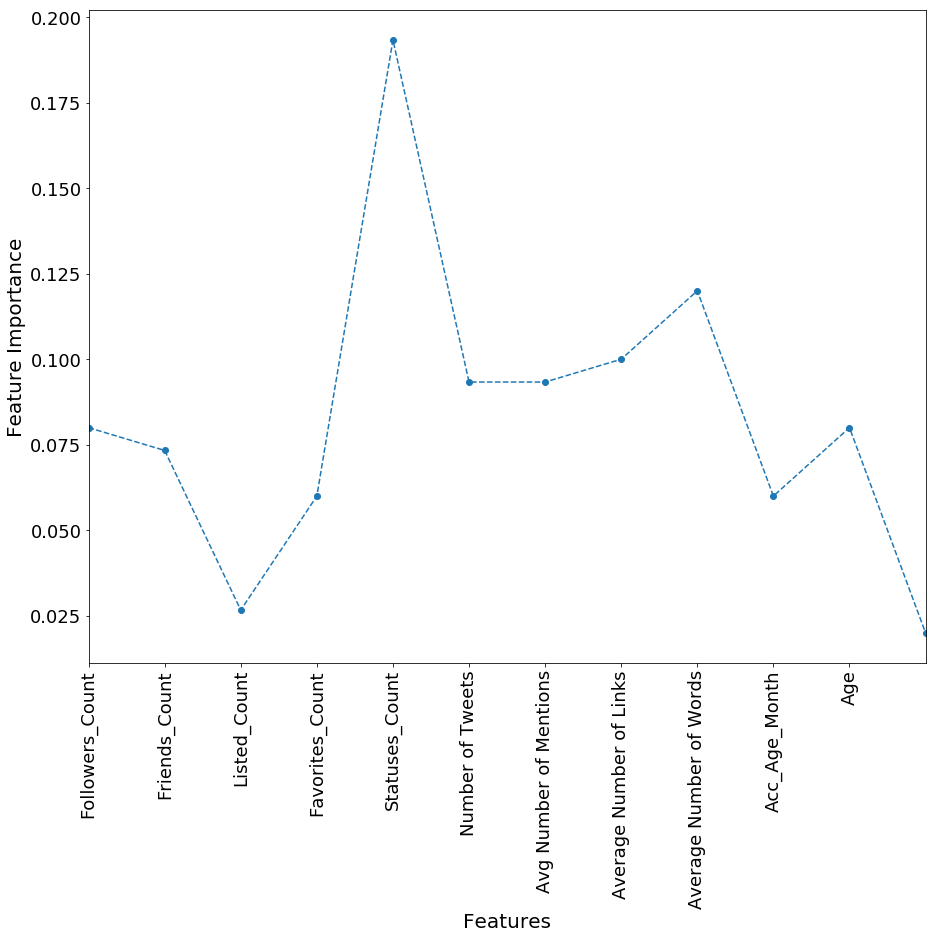

In [21]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 1.2.5 GradientBoosting Classifier

In [22]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,exponential,20,0.1,150,0,0.5


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.911277072442121

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4913    84     4997
True         510  1188     1698
__all__     5423  1272     6695

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.9003484320557491

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2131    57     2188
True         229   453      682
__all__     2360   510     2870

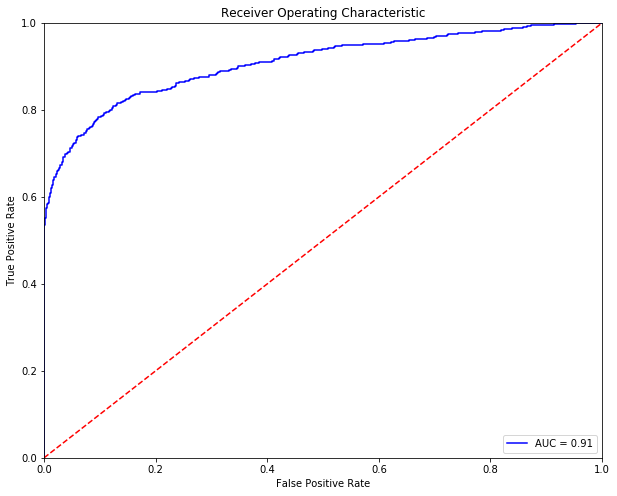

Optimal Threshold is 0.15493209730406887
Accuracy on test data is: 0.8358885017421602


Predicted  False  True  __all__
Actual                         
False       1830   358     2188
True         113   569      682
__all__     1943   927     2870

In [23]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [24]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

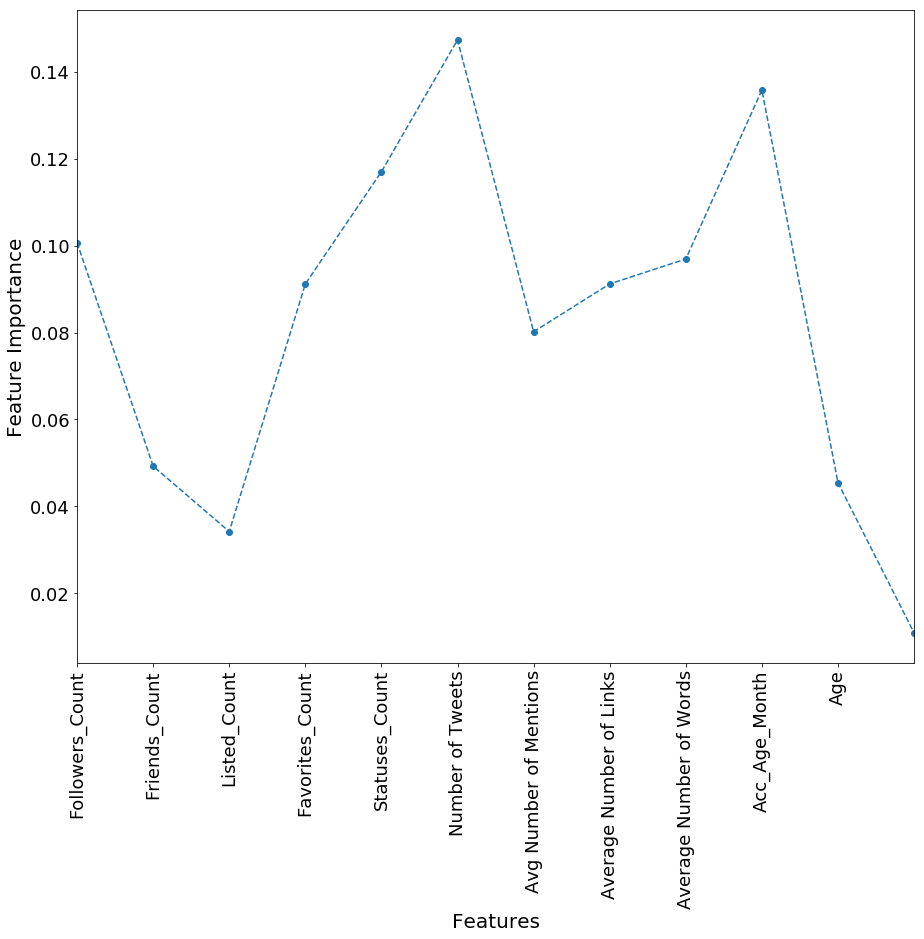

In [25]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 1.2.6 ExtraTree Classifier

In [26]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,entropy,20,auto,0.001,5,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8948469006721433

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4847   150     4997
True         554  1144     1698
__all__     5401  1294     6695

Accuracy of the  Extra Decision Tree  model for test data is: 0.8874564459930313

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2111    77     2188
True         246   436      682
__all__     2357   513     2870

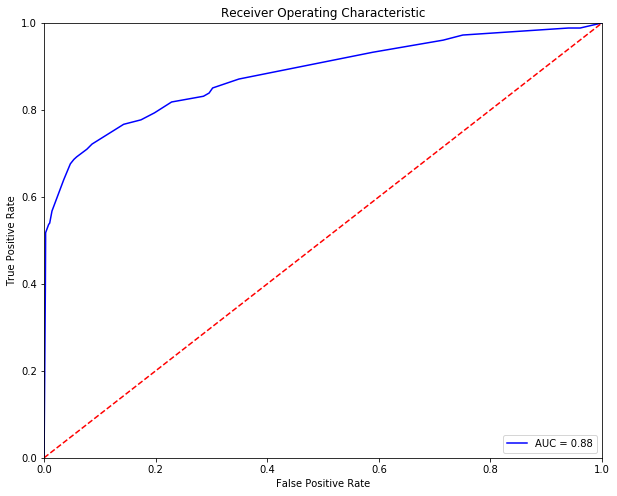

Optimal Threshold is 0.20437956204379562
Accuracy on test data is: 0.8146341463414634


Predicted  False  True  __all__
Actual                         
False       1808   380     2188
True         152   530      682
__all__     1960   910     2870

In [27]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [28]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

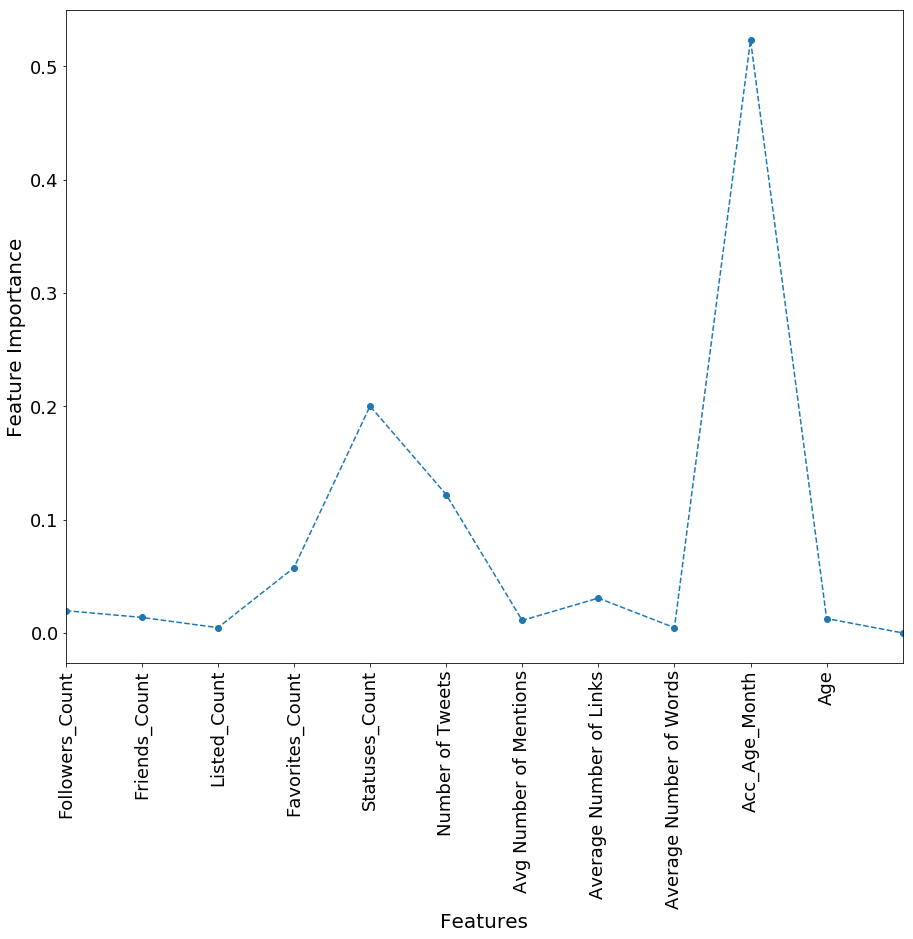

In [29]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 1.2.7 Bagging Classifier

In [30]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.3,300,True,0


Accuracy of the  Bagging  model for the training data is: 0.9293502613890964

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4997     0     4997
True         473  1225     1698
__all__     5470  1225     6695

Accuracy of the  Bagging  model for test data is: 0.8972125435540069

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2169    19     2188
True         276   406      682
__all__     2445   425     2870

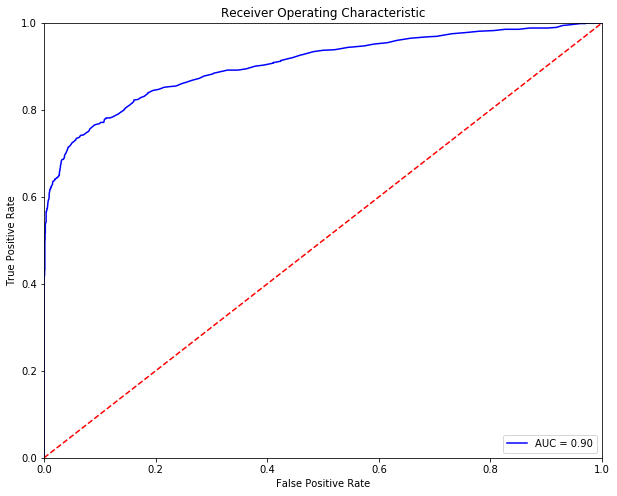

Optimal Threshold is 0.22
Accuracy on test data is: 0.8299651567944251


Predicted  False  True  __all__
Actual                         
False       1820   368     2188
True         120   562      682
__all__     1940   930     2870

In [31]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [32]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.8 Voting Classifier

In [33]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9351755041075429


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       4996     1     4997
True         433  1265     1698
__all__     5429  1266     6695

The test accuracy is: 0.8860627177700349


Predicted  False  True  __all__
Actual                         
False       2144    44     2188
True         283   399      682
__all__     2427   443     2870

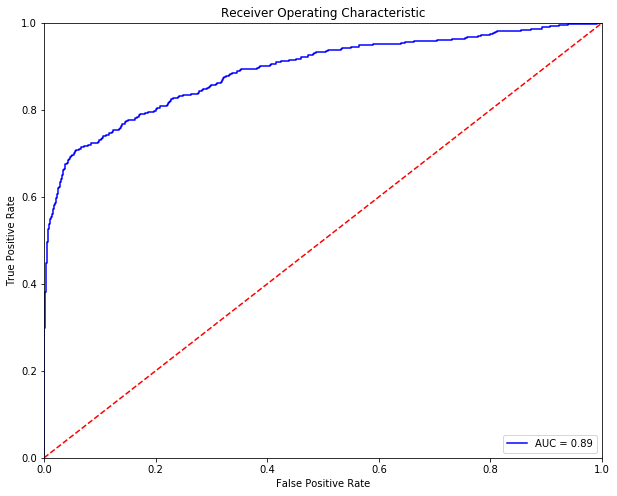

Optimal Threshold is 0.2515644383353073
Accuracy on test data is: 0.7996515679442509


Predicted  False  True  __all__
Actual                         
False       1750   438     2188
True         137   545      682
__all__     1887   983     2870

In [34]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [35]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.9 Deep Learning

In [36]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=12))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.9317401045645414


Predicted  False  True  __all__
Actual                         
False       4910    87     4997
True         370  1328     1698
__all__     5280  1415     6695

The accuracy of the model on test data is: 0.8804878048780488


Predicted  False  True  __all__
Actual                         
False       2077   111     2188
True         232   450      682
__all__     2309   561     2870

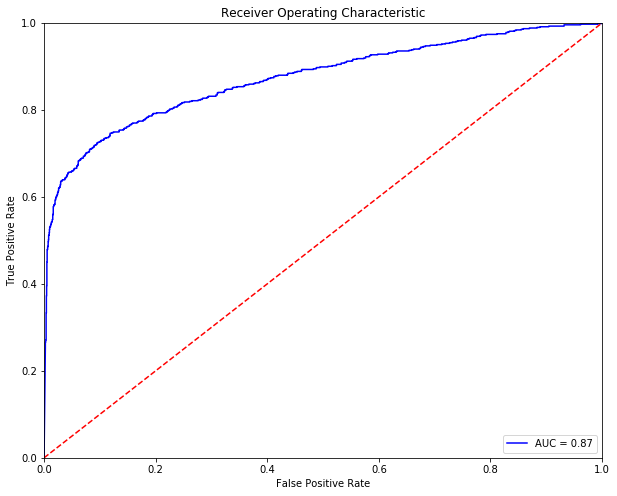

Optimal Threshold is 0.16864425
Accuracy of Logistic Model on training data is: 0.7968641114982579


Predicted  False  True  __all__
Actual                         
False       1747   441     2188
True         142   540      682
__all__     1889   981     2870

In [37]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [38]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.10 Deep Learning with Grid Search

In [39]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=12))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   56.7s finished


The accuracy of the model on training data is: 0.8519790888722928


Predicted  False  True  __all__
Actual                         
False       4879   118     4997
True         873   825     1698
__all__     5752   943     6695

The accuracy of the model on test data is: 0.8543554006968641


Predicted  False  True  __all__
Actual                         
False       2130    58     2188
True         360   322      682
__all__     2490   380     2870

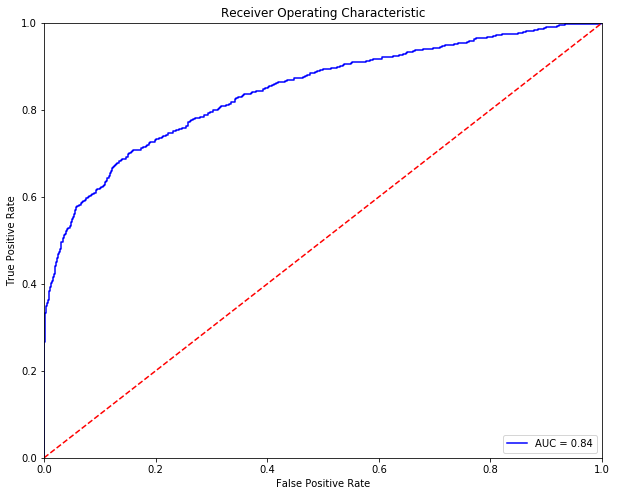

Optimal Threshold is 0.200459
Accuracy on test data is: 0.7547038327526132


Predicted  False  True  __all__
Actual                         
False       1651   537     2188
True         167   515      682
__all__     1818  1052     2870

In [40]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [41]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### <a id='#1.2.1' style="text-decoration : none; color: #000000;">1.2.1 Results </a>

In [42]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1698.0,4997.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.830620,759.0,4802.0,195.0,939.0,0.039023,0.553004
RandomForestClassifier,0.844212,655.0,4997.0,0.0,1043.0,0.000000,0.614252
AdaBoostClassifier,0.906199,1151.0,4916.0,81.0,547.0,0.016210,0.322144
GradientBoostingClassifier,0.911277,1188.0,4913.0,84.0,510.0,0.016810,0.300353
ExtraTreeClassifier,0.894847,1144.0,4847.0,150.0,554.0,0.030018,0.326266
BaggingClassifier,0.929350,1225.0,4997.0,0.0,473.0,0.000000,0.278563
VotingClassifier,0.935176,1265.0,4996.0,1.0,433.0,0.000200,0.255006
Neural Network-1,0.931740,1328.0,4910.0,87.0,370.0,0.017410,0.217903


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.867944,341.0,2150.0,38.0,341.0,0.017367,0.500000
LogisticRegression,0.833798,295.0,2098.0,90.0,387.0,0.041133,0.567449
RandomForestClassifier,0.851568,256.0,2188.0,0.0,426.0,0.000000,0.624633
AdaBoostClassifier,0.898258,440.0,2138.0,50.0,242.0,0.022852,0.354839
GradientBoostingClassifier,0.900348,453.0,2131.0,57.0,229.0,0.026051,0.335777
ExtraTreeClassifier,0.887456,436.0,2111.0,77.0,246.0,0.035192,0.360704
BaggingClassifier,0.897213,406.0,2169.0,19.0,276.0,0.008684,0.404692
VotingClassifier,0.886063,399.0,2144.0,44.0,283.0,0.020110,0.414956
Neural Network-1,0.880488,450.0,2077.0,111.0,232.0,0.050731,0.340176


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.751568,512.0,1645.0,543.0,170.0,0.248172,0.249267,0.170718,0.849369
LogisticRegression,0.705226,480.0,1544.0,644.0,202.0,0.294333,0.296188,0.227376,0.786162
RandomForestClassifier,0.849826,354.0,2085.0,103.0,328.0,0.047075,0.480938,0.200354,0.746978
AdaBoostClassifier,0.821951,560.0,1799.0,389.0,122.0,0.177788,0.178886,0.494405,0.899629
GradientBoostingClassifier,0.835889,569.0,1830.0,358.0,113.0,0.163620,0.165689,0.154932,0.907782
ExtraTreeClassifier,0.814634,530.0,1808.0,380.0,152.0,0.173675,0.222874,0.204380,0.880857
BaggingClassifier,0.829965,562.0,1820.0,368.0,120.0,0.168190,0.175953,0.220000,0.904917
VotingClassifier,0.799652,545.0,1750.0,438.0,137.0,0.200183,0.200880,0.251564,0.889938
Neural Network-1,0.796864,540.0,1747.0,441.0,142.0,0.201554,0.208211,0.168644,0.873034


###  <a id='1.3' style="text-decoration : none; color: #000000;"> 1.3  80:20 Train Test split </a>

In [43]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [44]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 1.3.1 KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,20,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       5715     0     5715
True           0  1937     1937
__all__     5715  1937     7652

Accuracy of the  KNN  model for test data is: 0.8719289074751699

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1440    30     1470
True         215   228      443
__all__     1655   258     1913

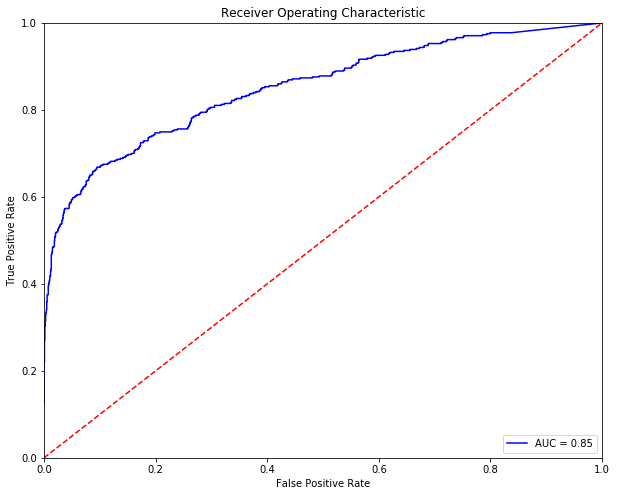

Optimal Threshold is 0.16924678430349993
Accuracy on test data is: 0.759539989545217


Predicted  False  True  __all__
Actual                         
False       1119   351     1470
True         109   334      443
__all__     1228   685     1913

In [46]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [47]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.2 Logistic Regression

In [48]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.5,False,True,0.7,10000,ovr,l2,sag,0.1


Accuracy of the  Logistic  model for the training data is: 0.8316779926816519

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       5524   191     5715
True        1097   840     1937
__all__     6621  1031     7652

Accuracy of the  Logistic  model for test data is: 0.8384736016727653

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1422    48     1470
True         261   182      443
__all__     1683   230     1913

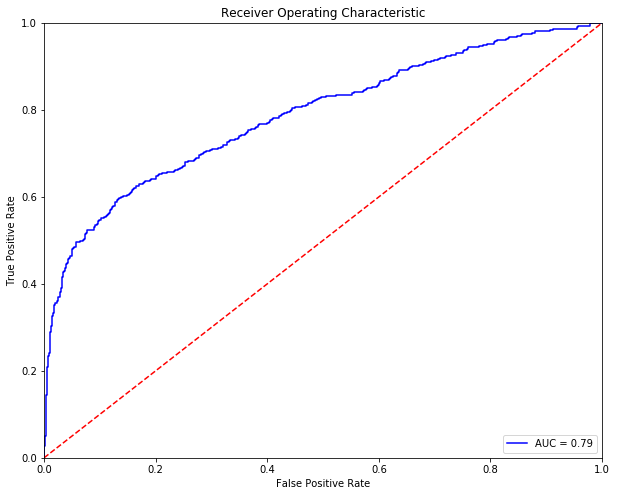

Optimal Threshold is 0.2197495478835665
Accuracy on test data is: 0.7088342916884475


Predicted  False  True  __all__
Actual                         
False       1044   426     1470
True         131   312      443
__all__     1175   738     1913

In [49]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [50]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.3 Random Forest CLassifier 

In [51]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,entropy,10,auto,10,0.1,10,10,0.1,500,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.8438316779926817

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       5715     0     5715
True        1195   742     1937
__all__     6910   742     7652

Accuracy of the  Random Forest Trees  model for test data is: 0.8557239937271301

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1470     0     1470
True         276   167      443
__all__     1746   167     1913

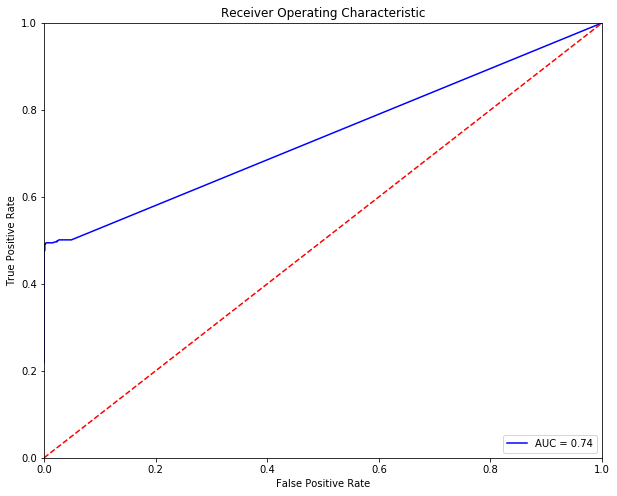

Optimal Threshold is 0.20071577179713015
Accuracy on test data is: 0.8484056455828541


Predicted  False  True  __all__
Actual                         
False       1401    69     1470
True         221   222      443
__all__     1622   291     1913

In [52]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [53]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

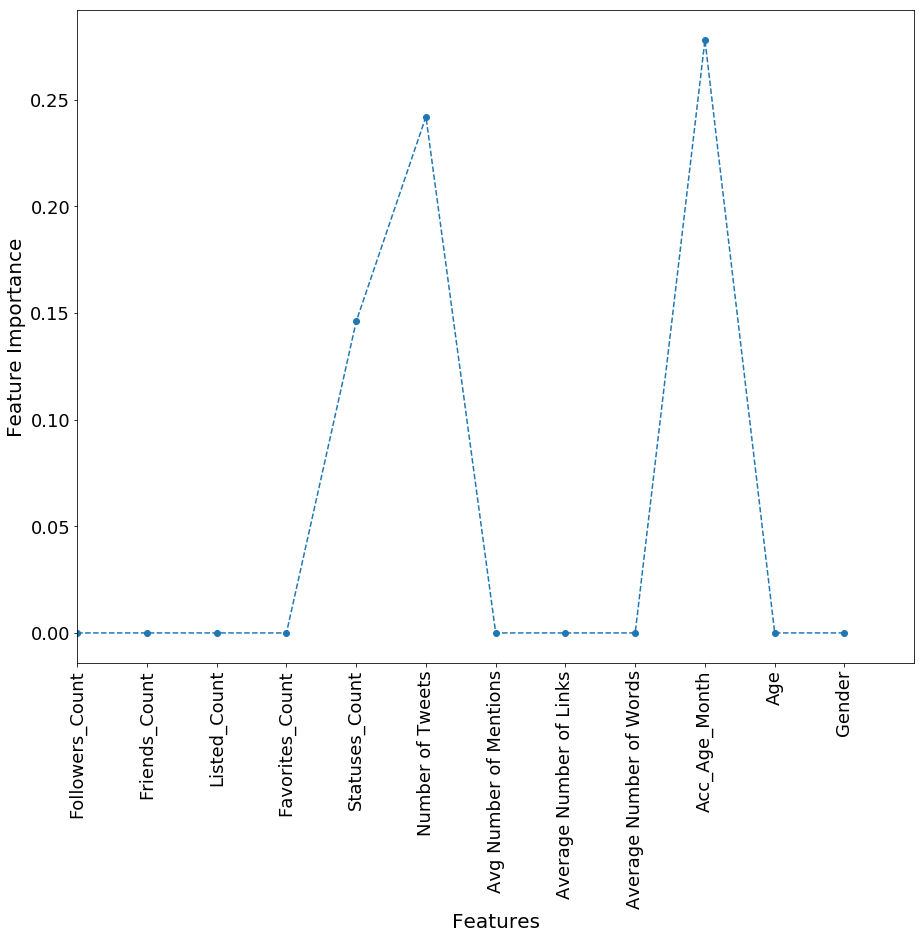

In [54]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 1.3.4 AdaBoost Classifier 

In [55]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,1,400,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.9046001045478307

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       5619    96     5715
True         634  1303     1937
__all__     6253  1399     7652

Accuracy of the  AdaBoostClassifier  model for test data is: 0.8959749085206482

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1432    38     1470
True         161   282      443
__all__     1593   320     1913

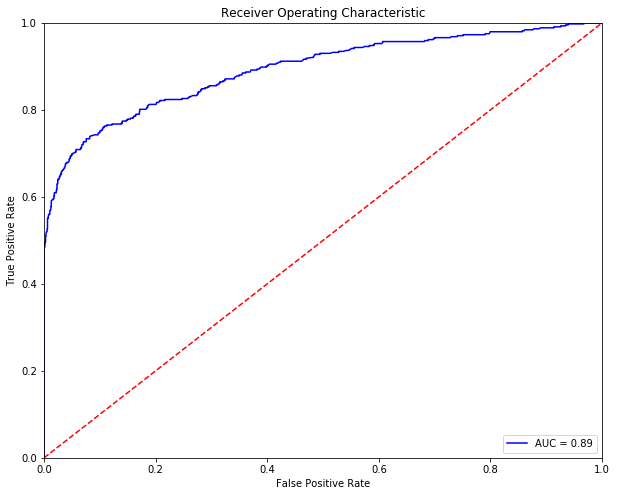

Optimal Threshold is 0.4915923752264883
Accuracy on test data is: 0.8123366440146367


Predicted  False  True  __all__
Actual                         
False       1195   275     1470
True          84   359      443
__all__     1279   634     1913

In [56]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [57]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

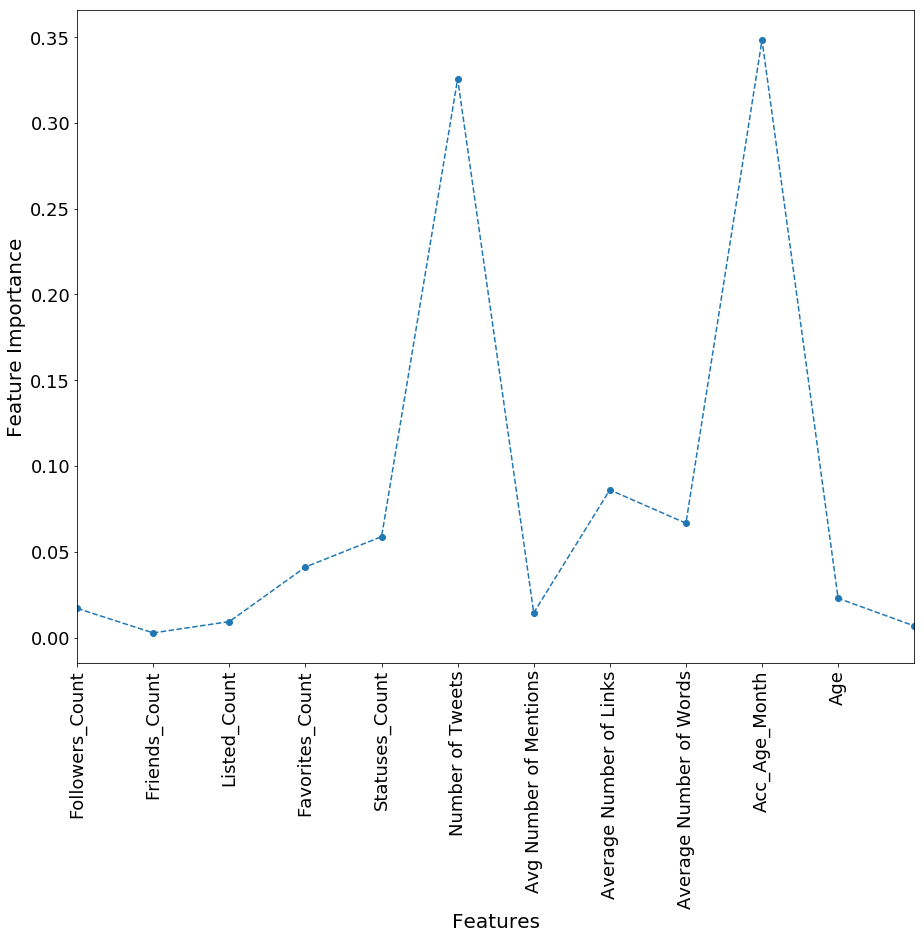

In [58]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 1.3.5 GradientBoosting Classifier

In [59]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,20,0.2,150,0,0.5


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.9106116048092002

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       5631    84     5715
True         600  1337     1937
__all__     6231  1421     7652

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.9012023000522739

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1442    28     1470
True         161   282      443
__all__     1603   310     1913

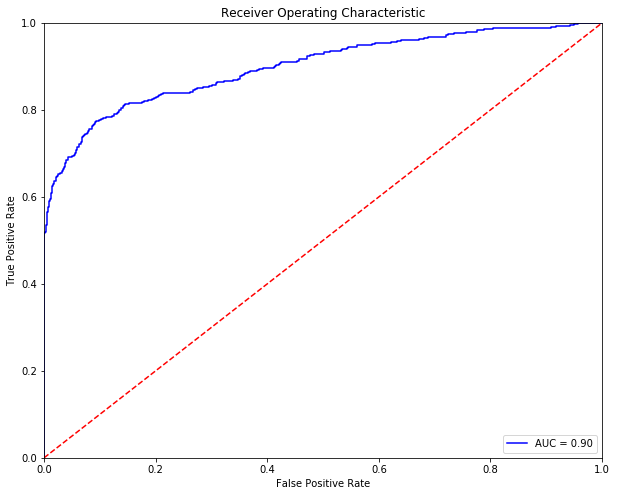

Optimal Threshold is 0.14913036229559018
Accuracy on test data is: 0.8201777313120753


Predicted  False  True  __all__
Actual                         
False       1207   263     1470
True          81   362      443
__all__     1288   625     1913

In [60]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [61]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

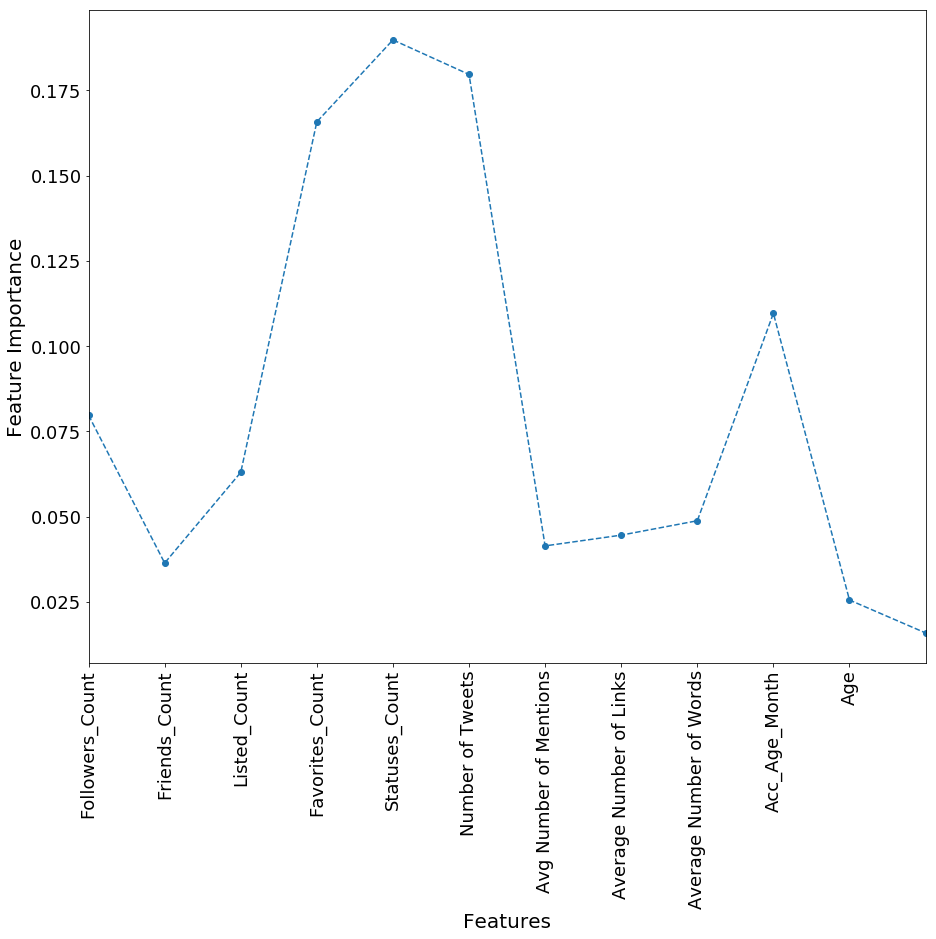

In [62]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 1.3.6 ExtraTree Classifier

In [63]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,gini,10,auto,0.001,2,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8945373758494511

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       5532   183     5715
True         624  1313     1937
__all__     6156  1496     7652

Accuracy of the  Extra Decision Tree  model for test data is: 0.886565603763722

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1419    51     1470
True         166   277      443
__all__     1585   328     1913

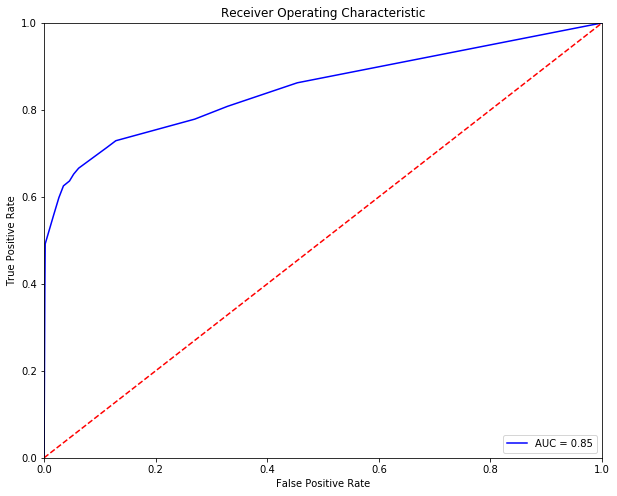

Optimal Threshold is 0.14617169373549885
Accuracy on test data is: 0.8384736016727653


Predicted  False  True  __all__
Actual                         
False       1281   189     1470
True         120   323      443
__all__     1401   512     1913

In [64]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [65]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

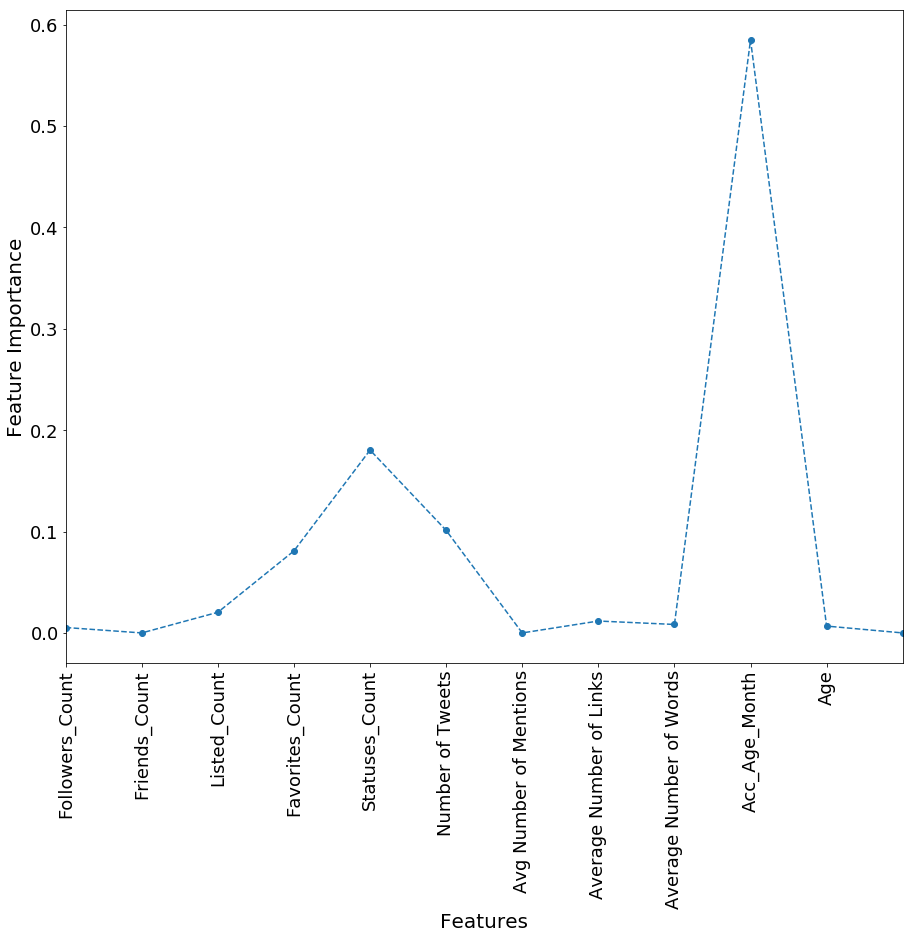

In [66]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 1.3.7 Bagging Classifier

In [67]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.4,500,True,0


Accuracy of the  Bagging  model for the training data is: 0.946549921589127

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       5715     0     5715
True         409  1528     1937
__all__     6124  1528     7652

Accuracy of the  Bagging  model for test data is: 0.9001568217459488

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1459    11     1470
True         180   263      443
__all__     1639   274     1913

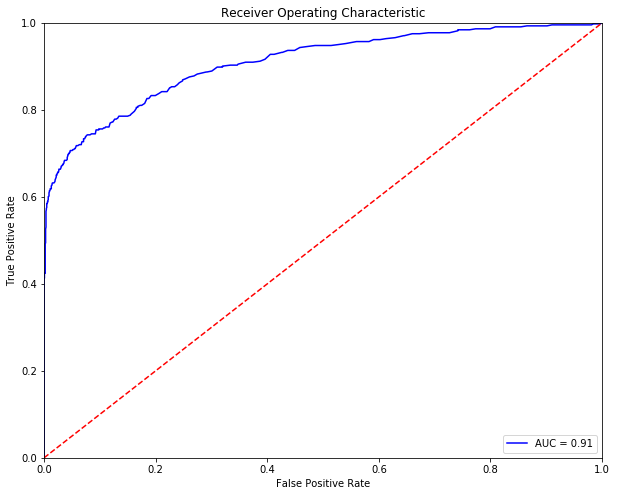

Optimal Threshold is 0.21
Accuracy on test data is: 0.821745948771563


Predicted  False  True  __all__
Actual                         
False       1213   257     1470
True          84   359      443
__all__     1297   616     1913

In [68]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [69]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.8 Voting Classifier

In [70]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9351803450078411


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       5713     2     5715
True         494  1443     1937
__all__     6207  1445     7652

The test accuracy is: 0.8870883429168844


Predicted  False  True  __all__
Actual                         
False       1444    26     1470
True         190   253      443
__all__     1634   279     1913

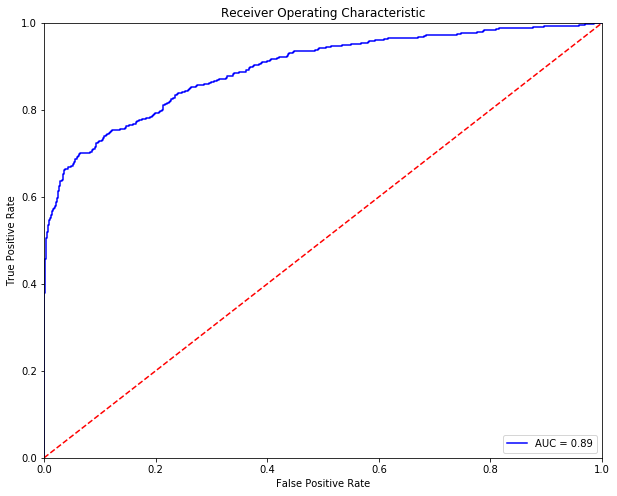

Optimal Threshold is 0.24702246731995073
Accuracy on test data is: 0.7940407736539467


Predicted  False  True  __all__
Actual                         
False       1168   302     1470
True          92   351      443
__all__     1260   653     1913

In [71]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [72]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.9 Deep Learning

In [73]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=12))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.926424464192368


Predicted  False  True  __all__
Actual                         
False       5662    53     5715
True         510  1427     1937
__all__     6172  1480     7652

The accuracy of the model on test data is: 0.8891792995295348


Predicted  False  True  __all__
Actual                         
False       1416    54     1470
True         158   285      443
__all__     1574   339     1913

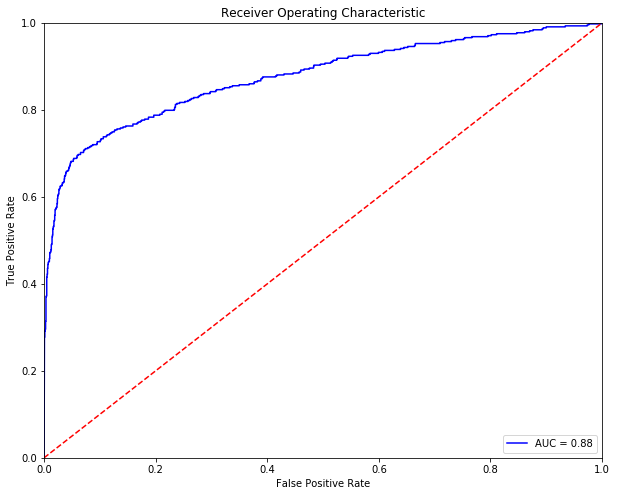

Optimal Threshold is 0.09202268
Accuracy of Logistic Model on training data is: 0.7893361212754836


Predicted  False  True  __all__
Actual                         
False       1160   310     1470
True          93   350      443
__all__     1253   660     1913

In [74]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [75]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.10 Deep Learning with Grid Search

In [76]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=12))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.6min finished


The accuracy of the model on training data is: 0.8527182435964453


Predicted  False  True  __all__
Actual                         
False       5452   263     5715
True         864  1073     1937
__all__     6316  1336     7652

The accuracy of the model on test data is: 0.8489283847360167


Predicted  False  True  __all__
Actual                         
False       1389    81     1470
True         208   235      443
__all__     1597   316     1913

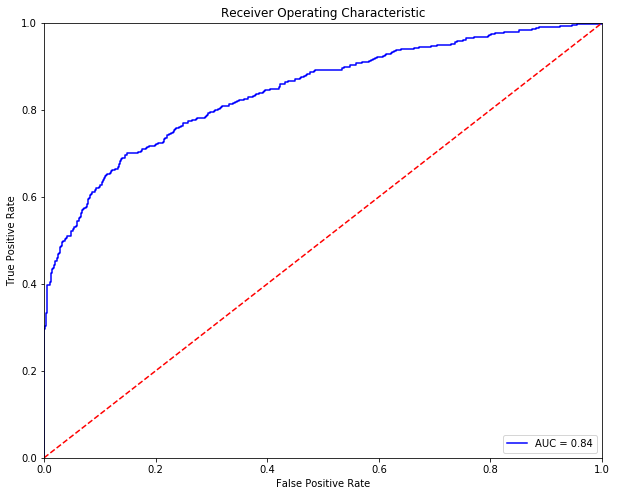

Optimal Threshold is 0.18881437
Accuracy on test data is: 0.7590172503920544


Predicted  False  True  __all__
Actual                         
False       1116   354     1470
True         107   336      443
__all__     1223   690     1913

In [77]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [78]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### <a id='#1.3.1' style="text-decoration : none; color: #000000;">1.3.1 Results </a>

In [79]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1937.0,5715.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.831678,840.0,5524.0,191.0,1097.0,0.033421,0.566340
RandomForestClassifier,0.843832,742.0,5715.0,0.0,1195.0,0.000000,0.616933
AdaBoostClassifier,0.904600,1303.0,5619.0,96.0,634.0,0.016798,0.327310
GradientBoostingClassifier,0.910612,1337.0,5631.0,84.0,600.0,0.014698,0.309757
ExtraTreeClassifier,0.894537,1313.0,5532.0,183.0,624.0,0.032021,0.322148
BaggingClassifier,0.946550,1528.0,5715.0,0.0,409.0,0.000000,0.211151
VotingClassifier,0.935180,1443.0,5713.0,2.0,494.0,0.000350,0.255034
Neural Network-1,0.926424,1427.0,5662.0,53.0,510.0,0.009274,0.263294


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.871929,228.0,1440.0,30.0,215.0,0.020408,0.485327
LogisticRegression,0.838474,182.0,1422.0,48.0,261.0,0.032653,0.589165
RandomForestClassifier,0.855724,167.0,1470.0,0.0,276.0,0.000000,0.623025
AdaBoostClassifier,0.895975,282.0,1432.0,38.0,161.0,0.025850,0.363431
GradientBoostingClassifier,0.901202,282.0,1442.0,28.0,161.0,0.019048,0.363431
ExtraTreeClassifier,0.886566,277.0,1419.0,51.0,166.0,0.034694,0.374718
BaggingClassifier,0.900157,263.0,1459.0,11.0,180.0,0.007483,0.406321
VotingClassifier,0.887088,253.0,1444.0,26.0,190.0,0.017687,0.428894
Neural Network-1,0.889179,285.0,1416.0,54.0,158.0,0.036735,0.356659


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.759540,334.0,1119.0,351.0,109.0,0.238776,0.246050,0.169247,0.850527
LogisticRegression,0.708834,312.0,1044.0,426.0,131.0,0.289796,0.295711,0.219750,0.786986
RandomForestClassifier,0.848406,222.0,1401.0,69.0,221.0,0.046939,0.498871,0.200716,0.738169
AdaBoostClassifier,0.812337,359.0,1195.0,275.0,84.0,0.187075,0.189616,0.491592,0.892512
GradientBoostingClassifier,0.820178,362.0,1207.0,263.0,81.0,0.178912,0.182844,0.149130,0.899008
ExtraTreeClassifier,0.838474,323.0,1281.0,189.0,120.0,0.128571,0.270880,0.146172,0.849215
BaggingClassifier,0.821746,359.0,1213.0,257.0,84.0,0.174830,0.189616,0.210000,0.908460
VotingClassifier,0.794041,351.0,1168.0,302.0,92.0,0.205442,0.207675,0.247022,0.894149
Neural Network-1,0.789336,350.0,1160.0,310.0,93.0,0.210884,0.209932,0.092023,0.875361


### <a id='2' style="text-decoration : none; color: #000000;"> 2 Vulnerable/Control 50:50</a>
#### <a id='2.1' style="text-decoration : none; color: #000000;"> 2.1 Loading Data </a>

In [80]:
df=pd.read_csv('Final_feature_set.csv',index_col=['Unnamed: 0'])
df.fillna(value=0,inplace=True)
df=df[df['Age']>=0]
df.head()

df2=df.copy(deep=True)
df2.drop(['User_Id','User_Name_x','Created_At','Language'],axis=1,inplace=True)
df2.set_index(['User_Screen_Name'],inplace=True,drop=True)
df2.Gender=df2.Gender.apply(lambda x: 1 if x=='F' else 0)
df2=df2[df2['Avg Number of Mentions']!='True']

df2.head()

,Followers_Count,Friends_Count,Listed_Count,Favorites_Count,Statuses_Count,Number of Tweets,Avg Number of Mentions,Average Number of Links,Average Number of Words,Acc_Age_Month,Malicious,Age,Gender
User_Screen_Name,,,,,,,,,,,,,
MichaelDeMers4,12,42,0,11,120,113,1.3628318584070795,0.23008849557522126,9.610619469026547,67.746332,0,32.561429,0
vanbastarache,61,223,1,1507,648,611,0.33387888707037644,0.1833060556464812,13.734860883797054,84.591551,0,26.093862,1
leslievanilla,743,414,3,5216,789,229,0.6724890829694323,0.0611353711790393,4.973799126637554,27.153099,1,21.084834,1
EVJ44,187,270,3,8753,605,226,0.6327433628318584,0.584070796460177,10.336283185840708,19.283745,1,20.619374,1
Leah10123,20,253,0,106,141,138,0.5507246376811594,0.8840579710144928,7.195652173913044,81.419931,0,22.270800,1


In [81]:
nm=df2[df2['Malicious']==0]
m=df2[df2['Malicious']==1]

df2=m.append(nm.sample(frac=2380/7185,random_state=0))

In [82]:
print("The number of Vulnerable/Control Cases:")
df2.Malicious.value_counts()

The number of Vulnerable/Control Cases:


1    2380
0    2380
Name: Malicious, dtype: int64

In [83]:
### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    display(cm)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy on test data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

#### <a id='2.2' style="text-decoration : none; color: #000000;"> 2.2  70: 30 Train Test split </a>

In [84]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [85]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 2.2.1 KNN

In [86]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,30,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1655     0     1655
True           0  1677     1677
__all__     1655  1677     3332

Accuracy of the  KNN  model for test data is: 0.7815126050420168

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        643    82      725
True         230   473      703
__all__      873   555     1428

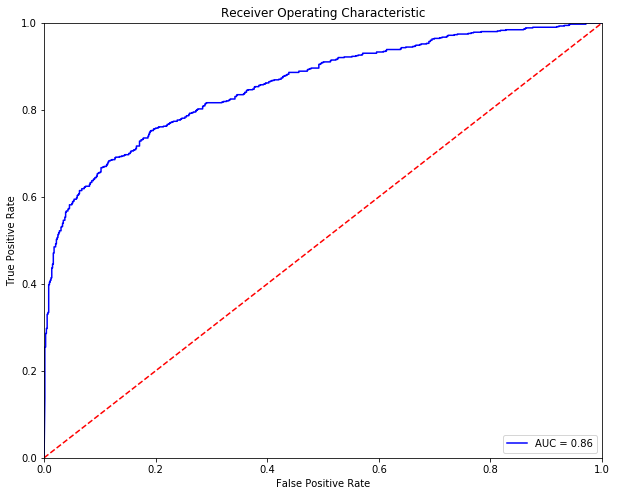

Optimal Threshold is 0.3884203887570841
Accuracy on test data is: 0.7717086834733894


Predicted  False  True  __all__
Actual                         
False        560   165      725
True         161   542      703
__all__      721   707     1428

In [87]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [88]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.2 Logistic Regression

In [89]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.5,False,True,0.5,10000,multinomial,l2,lbfgs,0.1


Accuracy of the  Logistic  model for the training data is: 0.7277911164465787

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1275   380     1655
True         527  1150     1677
__all__     1802  1530     3332

Accuracy of the  Logistic  model for test data is: 0.7415966386554622

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        563   162      725
True         207   496      703
__all__      770   658     1428

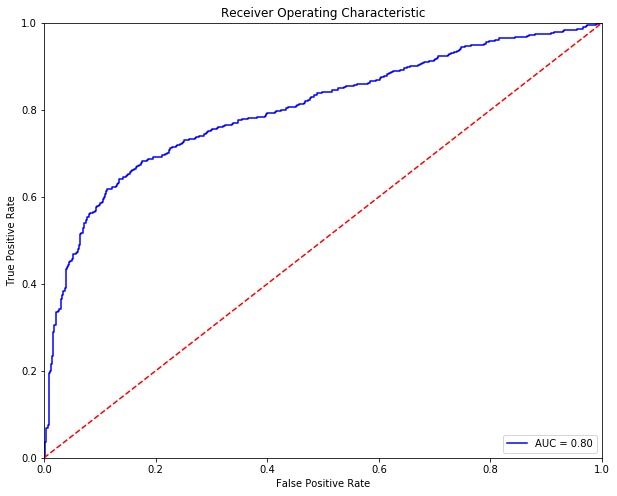

Optimal Threshold is 0.48210348363889693
Accuracy on test data is: 0.7331932773109243


Predicted  False  True  __all__
Actual                         
False        532   193      725
True         188   515      703
__all__      720   708     1428

In [90]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [91]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.3 RandomFOrest Classifier

In [92]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,gini,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.7575030012004802

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1655     0     1655
True         808   869     1677
__all__     2463   869     3332

Accuracy of the  Random Forest Trees  model for test data is: 0.7626050420168067

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        724     1      725
True         338   365      703
__all__     1062   366     1428

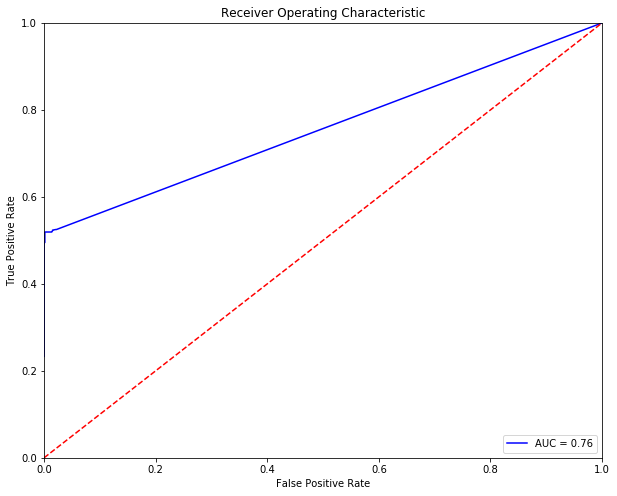

Optimal Threshold is 0.4301631068143077
Accuracy on test data is: 0.7556022408963585


Predicted  False  True  __all__
Actual                         
False        710    15      725
True         334   369      703
__all__     1044   384     1428

In [93]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [94]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

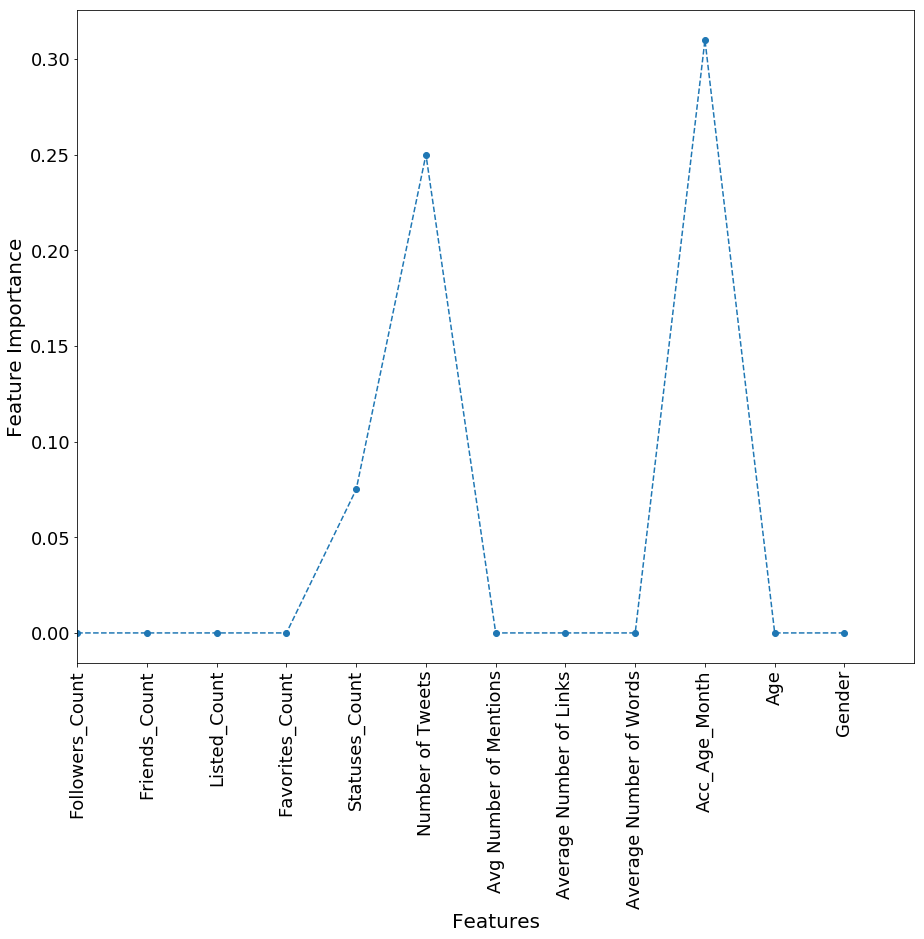

In [95]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 2.2.4 Ada Boost Classifier

In [96]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,0.5,400,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.8412364945978391

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1519   136     1655
True         393  1284     1677
__all__     1912  1420     3332

Accuracy of the  AdaBoostClassifier  model for test data is: 0.8389355742296919

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        678    47      725
True         183   520      703
__all__      861   567     1428

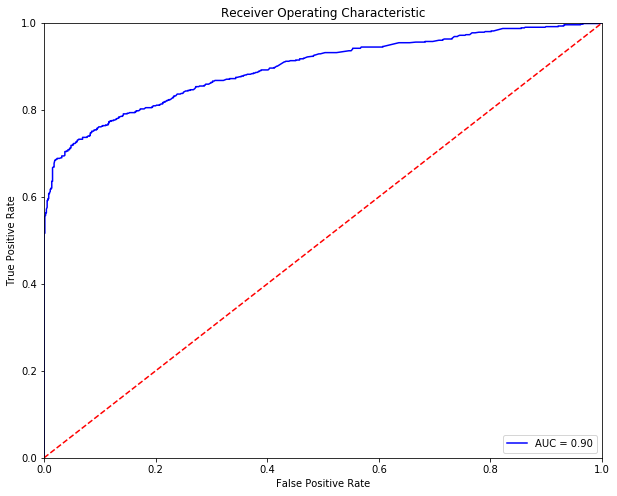

Optimal Threshold is 0.5000667947839204
Accuracy on test data is: 0.8060224089635855


Predicted  False  True  __all__
Actual                         
False        585   140      725
True         137   566      703
__all__      722   706     1428

In [97]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [98]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

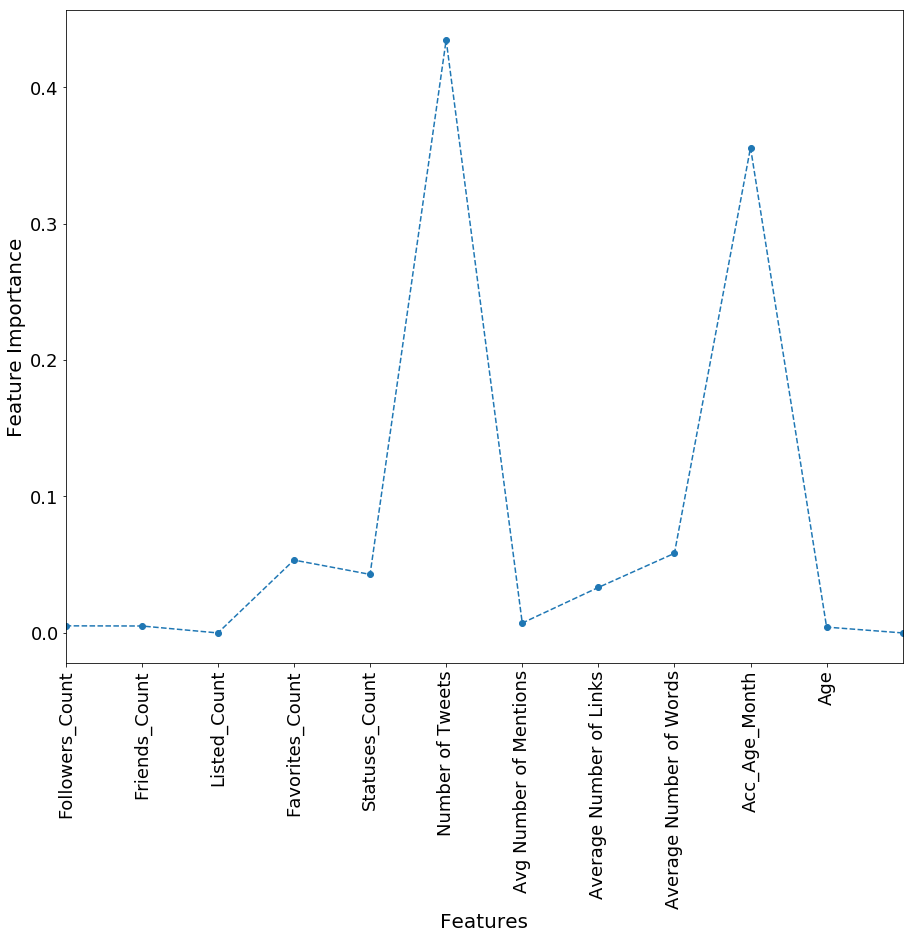

In [99]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 2.2.5 Gradient Boosting Classifier

In [100]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.03,deviance,5,0.1,150,0,0.5


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8514405762304922

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1539   116     1655
True         379  1298     1677
__all__     1918  1414     3332

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8382352941176471

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        675    50      725
True         181   522      703
__all__      856   572     1428

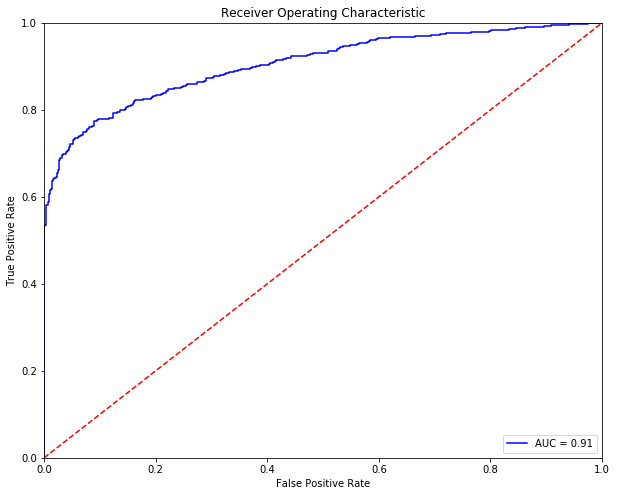

Optimal Threshold is 0.32611252820107434
Accuracy on test data is: 0.8242296918767507


Predicted  False  True  __all__
Actual                         
False        598   127      725
True         124   579      703
__all__      722   706     1428

In [101]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [102]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

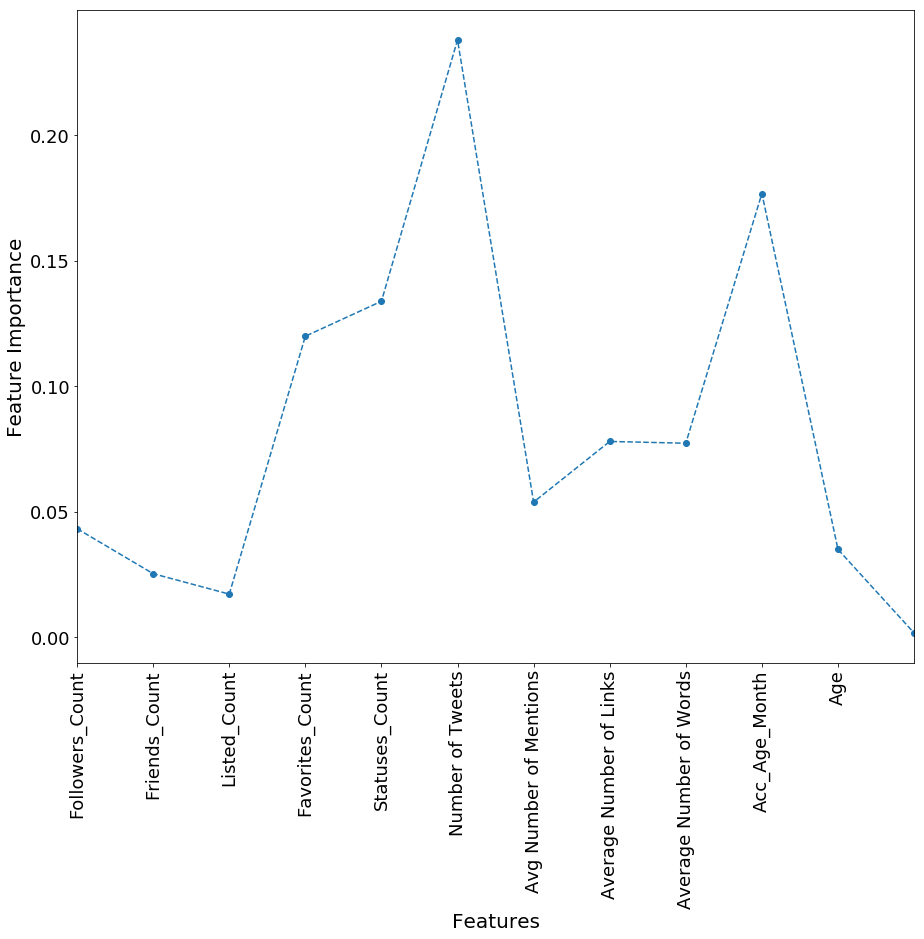

In [103]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 2.2.6 Extra Tree classifier

In [104]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,gini,10,auto,0.001,5,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8442376950780313

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1545   110     1655
True         409  1268     1677
__all__     1954  1378     3332

Accuracy of the  Extra Decision Tree  model for test data is: 0.8172268907563025

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        664    61      725
True         200   503      703
__all__      864   564     1428

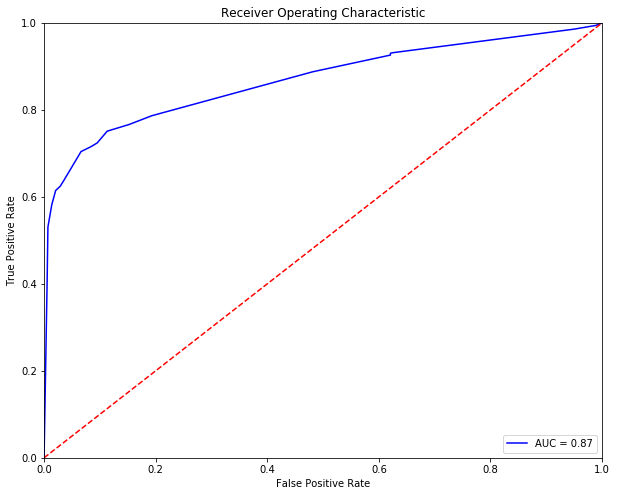

Optimal Threshold is 0.2608695652173913
Accuracy on test data is: 0.8067226890756303


Predicted  False  True  __all__
Actual                         
False        612   113      725
True         163   540      703
__all__      775   653     1428

In [105]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [106]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

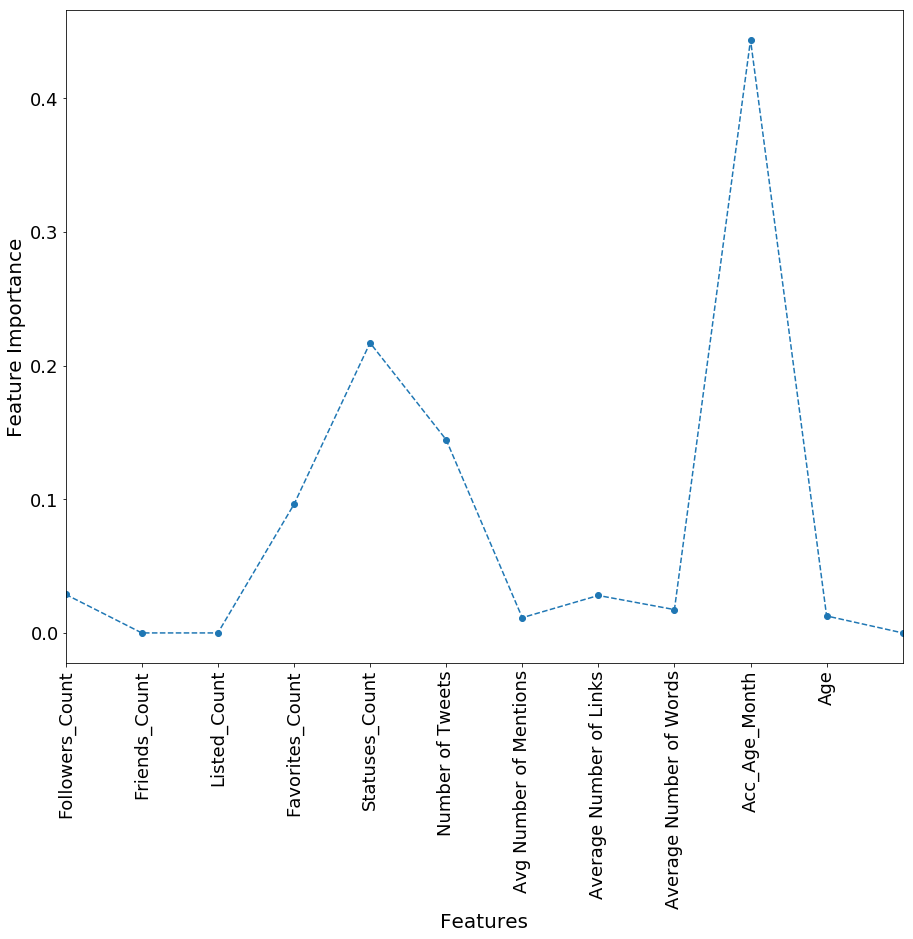

In [107]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 2.2.7 Bagging Classifier

In [108]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.4,100,True,0


Accuracy of the  Bagging  model for the training data is: 0.9693877551020408

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1644    11     1655
True          91  1586     1677
__all__     1735  1597     3332

Accuracy of the  Bagging  model for test data is: 0.8326330532212886

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        668    57      725
True         182   521      703
__all__      850   578     1428

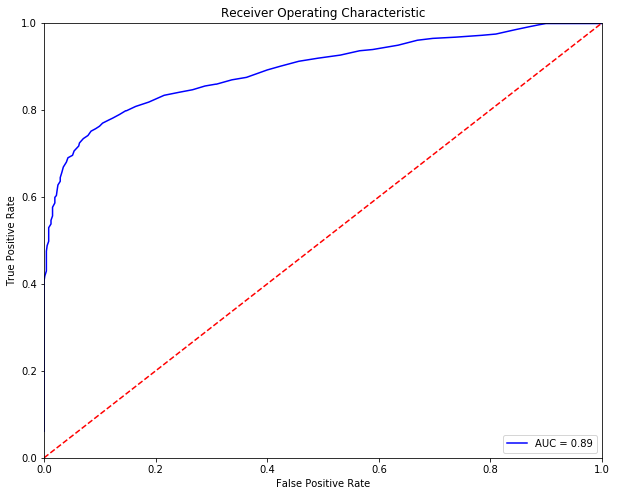

Optimal Threshold is 0.41
Accuracy on test data is: 0.8221288515406162


Predicted  False  True  __all__
Actual                         
False        606   119      725
True         135   568      703
__all__      741   687     1428

In [109]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [110]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.8 Voting Classifier

In [111]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9702881152460985


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       1645    10     1655
True          89  1588     1677
__all__     1734  1598     3332

The test accuracy is: 0.8123249299719888


Predicted  False  True  __all__
Actual                         
False        643    82      725
True         186   517      703
__all__      829   599     1428

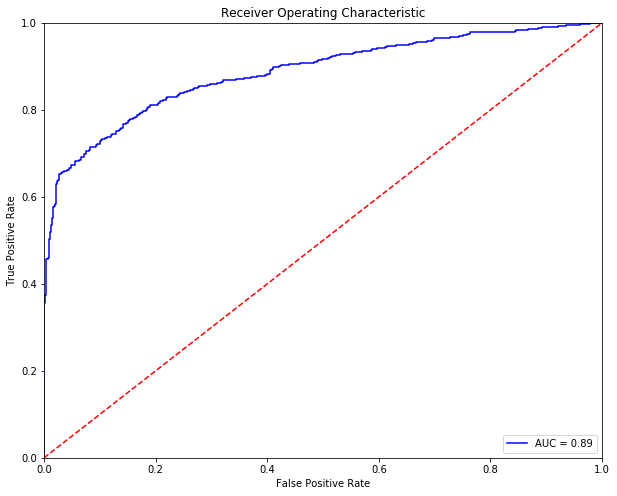

Optimal Threshold is 0.4341805177677979
Accuracy on test data is: 0.8102240896358543


Predicted  False  True  __all__
Actual                         
False        588   137      725
True         134   569      703
__all__      722   706     1428

In [112]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [113]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### 2.2.9 Deep Learning

In [114]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=12))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.897358943577431


Predicted  False  True  __all__
Actual                         
False       1567    88     1655
True         254  1423     1677
__all__     1821  1511     3332

The accuracy of the model on test data is: 0.8018207282913166


Predicted  False  True  __all__
Actual                         
False        609   116      725
True         167   536      703
__all__      776   652     1428

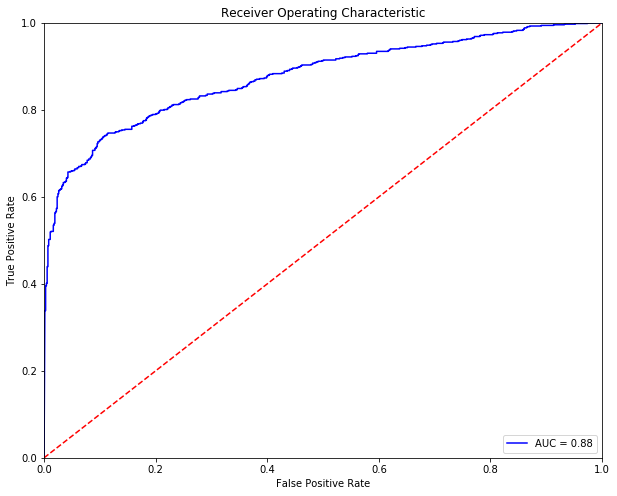

Optimal Threshold is 0.38934478
Accuracy of Logistic Model on training data is: 0.7941176470588235


Predicted  False  True  __all__
Actual                         
False        576   149      725
True         145   558      703
__all__      721   707     1428

In [115]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [116]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.10 Deep Learning with Grid Search

In [ ]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=12))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

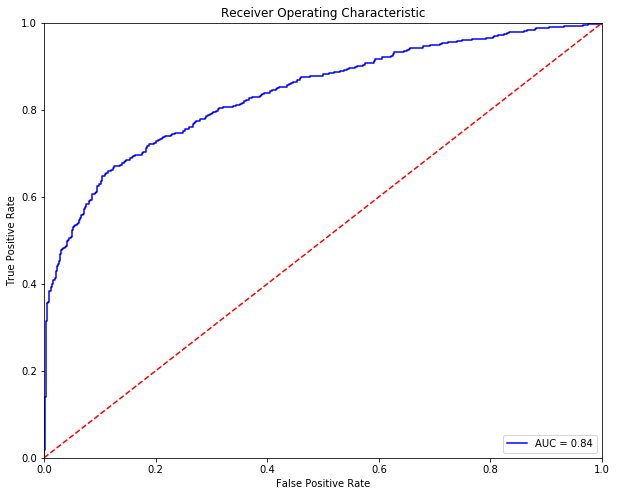

Optimal Threshold is 0.48499098
Accuracy on test data is: 0.75


Predicted  False  True  __all__
Actual                         
False        544   181      725
True         176   527      703
__all__      720   708     1428

In [118]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [119]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### <a id'#2.2.1' style="text-decoration : none; color: #000000;">2.2.1 Results </a></ol></ul>

In [120]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1677.0,1655.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.727791,1150.0,1275.0,380.0,527.0,0.229607,0.314252
RandomForestClassifier,0.757503,869.0,1655.0,0.0,808.0,0.000000,0.481813
AdaBoostClassifier,0.841236,1284.0,1519.0,136.0,393.0,0.082175,0.234347
GradientBoostingClassifier,0.851441,1298.0,1539.0,116.0,379.0,0.070091,0.225999
ExtraTreeClassifier,0.844238,1268.0,1545.0,110.0,409.0,0.066465,0.243888
BaggingClassifier,0.969388,1586.0,1644.0,11.0,91.0,0.006647,0.054264
VotingClassifier,0.970288,1588.0,1645.0,10.0,89.0,0.006042,0.053071
Neural Network-1,0.897359,1423.0,1567.0,88.0,254.0,0.053172,0.151461


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.781513,473.0,643.0,82.0,230.0,0.113103,0.327169
LogisticRegression,0.741597,496.0,563.0,162.0,207.0,0.223448,0.294452
RandomForestClassifier,0.762605,365.0,724.0,1.0,338.0,0.001379,0.480797
AdaBoostClassifier,0.838936,520.0,678.0,47.0,183.0,0.064828,0.260313
GradientBoostingClassifier,0.838235,522.0,675.0,50.0,181.0,0.068966,0.257468
ExtraTreeClassifier,0.817227,503.0,664.0,61.0,200.0,0.084138,0.284495
BaggingClassifier,0.832633,521.0,668.0,57.0,182.0,0.078621,0.258890
VotingClassifier,0.812325,517.0,643.0,82.0,186.0,0.113103,0.264580
Neural Network-1,0.801821,536.0,609.0,116.0,167.0,0.160000,0.237553


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.771709,542.0,560.0,165.0,161.0,0.227586,0.229018,0.388420,0.857840
LogisticRegression,0.733193,515.0,532.0,193.0,188.0,0.266207,0.267425,0.482103,0.801140
RandomForestClassifier,0.755602,369.0,710.0,15.0,334.0,0.020690,0.475107,0.430163,0.757082
AdaBoostClassifier,0.806022,566.0,585.0,140.0,137.0,0.193103,0.194879,0.500067,0.896397
GradientBoostingClassifier,0.824230,579.0,598.0,127.0,124.0,0.175172,0.176387,0.326113,0.905210
ExtraTreeClassifier,0.806723,540.0,612.0,113.0,163.0,0.155862,0.231863,0.260870,0.867711
BaggingClassifier,0.822129,568.0,606.0,119.0,135.0,0.164138,0.192034,0.410000,0.892793
VotingClassifier,0.810224,569.0,588.0,137.0,134.0,0.188966,0.190612,0.434181,0.885931
Neural Network-1,0.794118,558.0,576.0,149.0,145.0,0.205517,0.206259,0.389345,0.875706


###  <a id='2.3' style="text-decoration : none; color: #000000;"> 2.3  80:20 Train Test split </a>

In [121]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [122]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 2.3.1 KNN

In [123]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,30,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1899     0     1899
True           0  1909     1909
__all__     1899  1909     3808

Accuracy of the  KNN  model for test data is: 0.7888655462184874

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        434    47      481
True         154   317      471
__all__      588   364      952

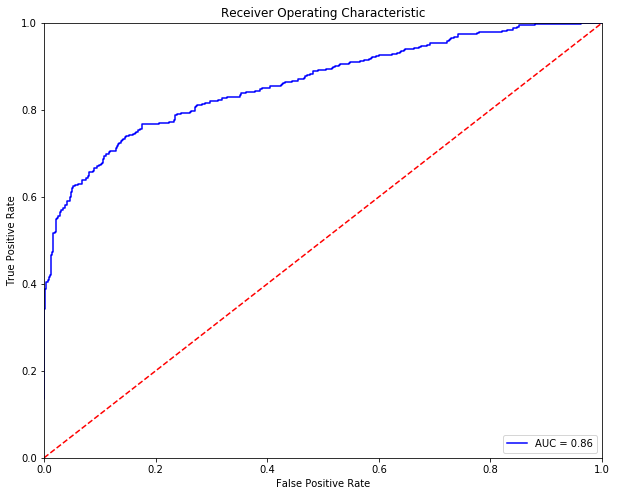

Optimal Threshold is 0.3846645912226249
Accuracy on test data is: 0.773109243697479


Predicted  False  True  __all__
Actual                         
False        373   108      481
True         108   363      471
__all__      481   471      952

In [124]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [125]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.3 Logistic Regression

In [126]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.5,False,True,0.5,10000,multinomial,l2,newton-cg,1e-05


Accuracy of the  Logistic  model for the training data is: 0.7274159663865546

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1465   434     1899
True         604  1305     1909
__all__     2069  1739     3808

Accuracy of the  Logistic  model for test data is: 0.7489495798319328

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        381   100      481
True         139   332      471
__all__      520   432      952

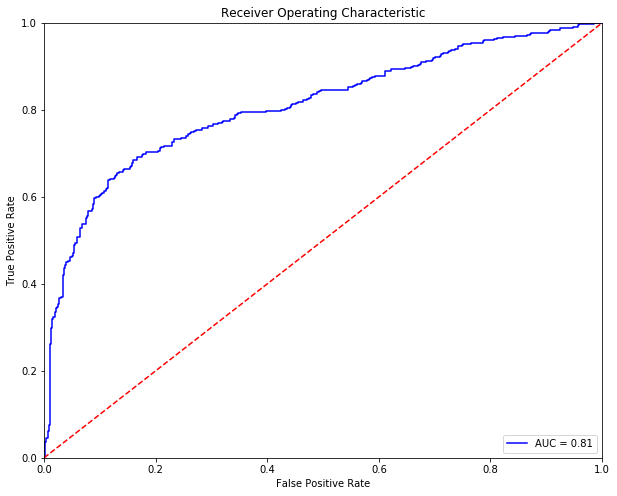

Optimal Threshold is 0.47974138173383646
Accuracy on test data is: 0.7426470588235294


Predicted  False  True  __all__
Actual                         
False        358   123      481
True         122   349      471
__all__      480   472      952

In [127]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [128]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.3 Random Forest CLassifiere

In [129]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,entropy,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.7589285714285714

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1899     0     1899
True         918   991     1909
__all__     2817   991     3808

Accuracy of the  Random Forest Trees  model for test data is: 0.759453781512605

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        480     1      481
True         228   243      471
__all__      708   244      952

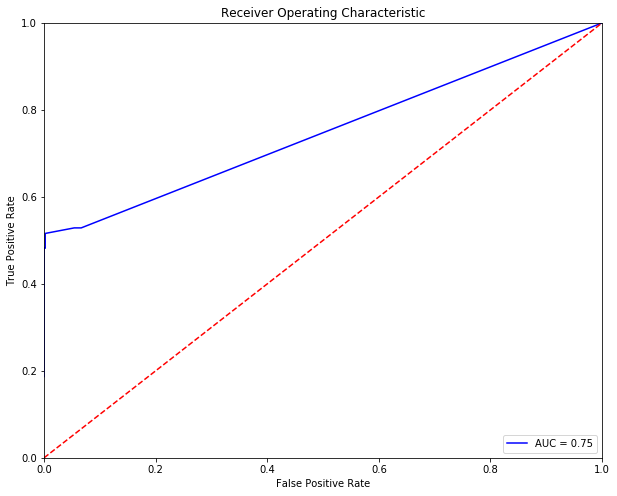

Optimal Threshold is 0.42036178067171087
Accuracy on test data is: 0.7394957983193278


Predicted  False  True  __all__
Actual                         
False        455    26      481
True         222   249      471
__all__      677   275      952

In [130]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [131]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

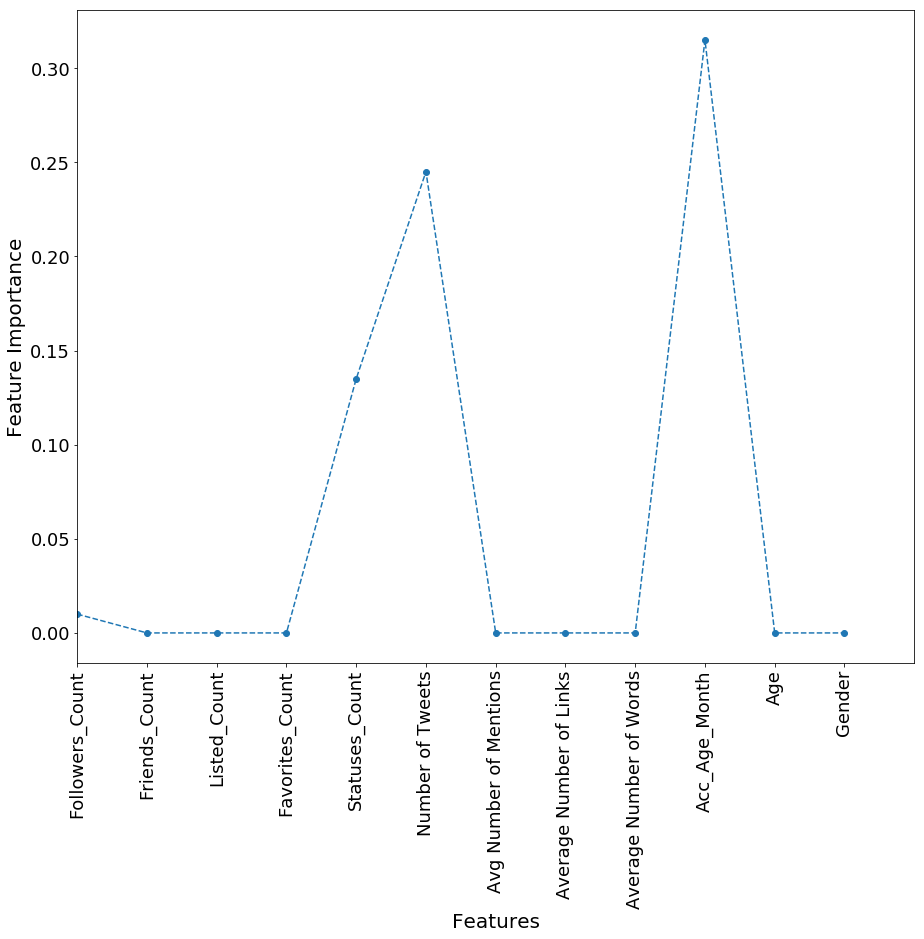

In [132]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 2.3.4 AdaBoost Classifier

In [133]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME.R,0.5,50,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.8448004201680672

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1737   162     1899
True         429  1480     1909
__all__     2166  1642     3808

Accuracy of the  AdaBoostClassifier  model for test data is: 0.8298319327731093

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        438    43      481
True         119   352      471
__all__      557   395      952

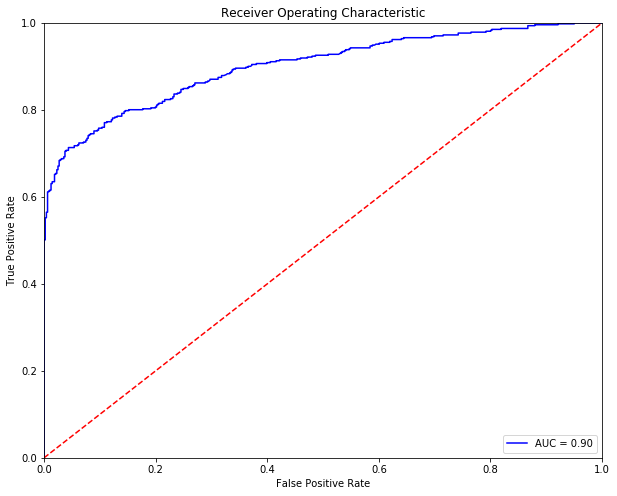

Optimal Threshold is 0.4928020319084936
Accuracy on test data is: 0.805672268907563


Predicted  False  True  __all__
Actual                         
False        389    92      481
True          93   378      471
__all__      482   470      952

In [134]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [135]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

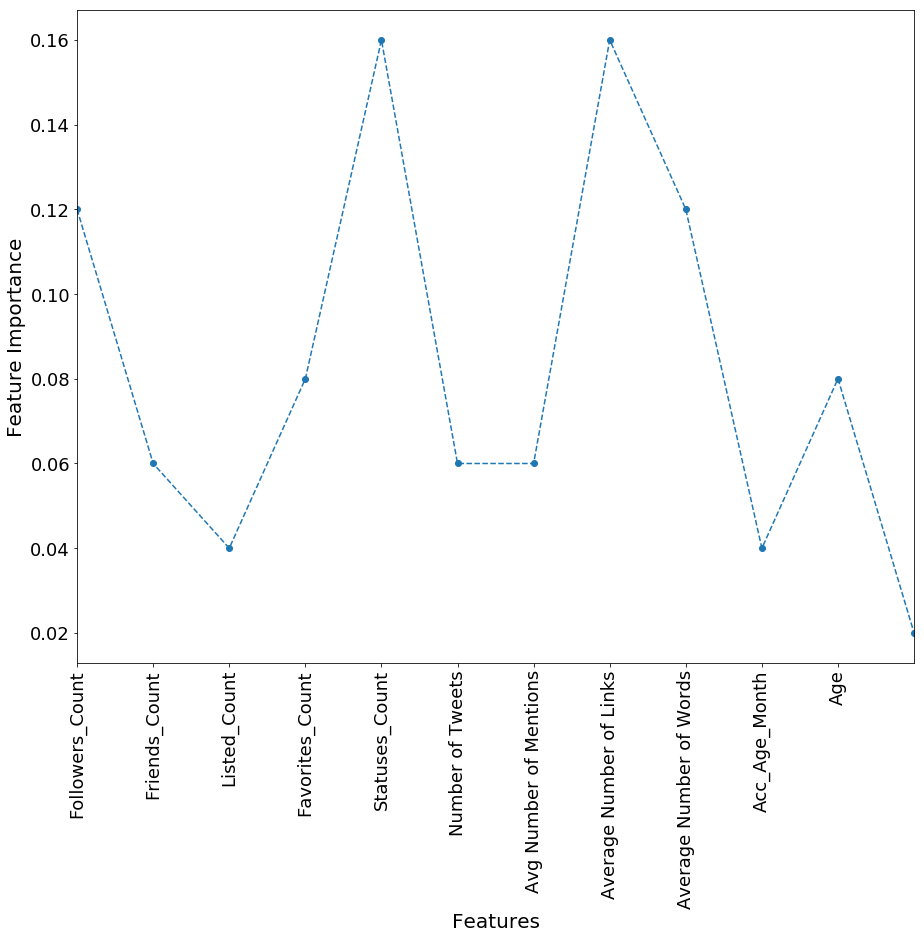

In [136]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 2.3.5 Gradient Boosting Classifier

In [137]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,exponential,15,0.1,100,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8608193277310925

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1771   128     1899
True         402  1507     1909
__all__     2173  1635     3808

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8413865546218487

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        444    37      481
True         114   357      471
__all__      558   394      952

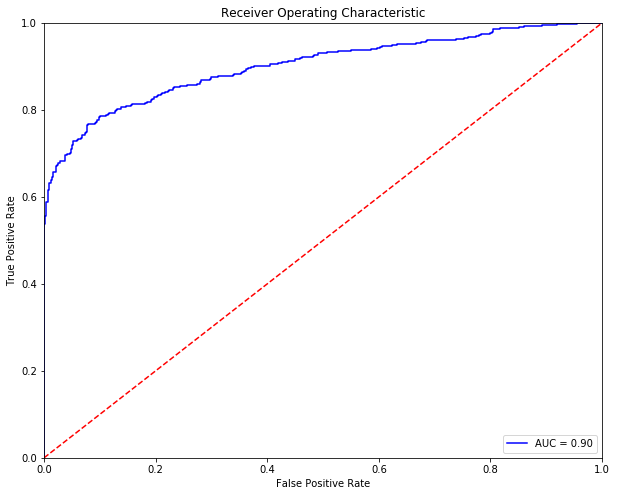

Optimal Threshold is 0.31449596215805803
Accuracy on test data is: 0.8161764705882353


Predicted  False  True  __all__
Actual                         
False        393    88      481
True          87   384      471
__all__      480   472      952

In [138]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [139]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

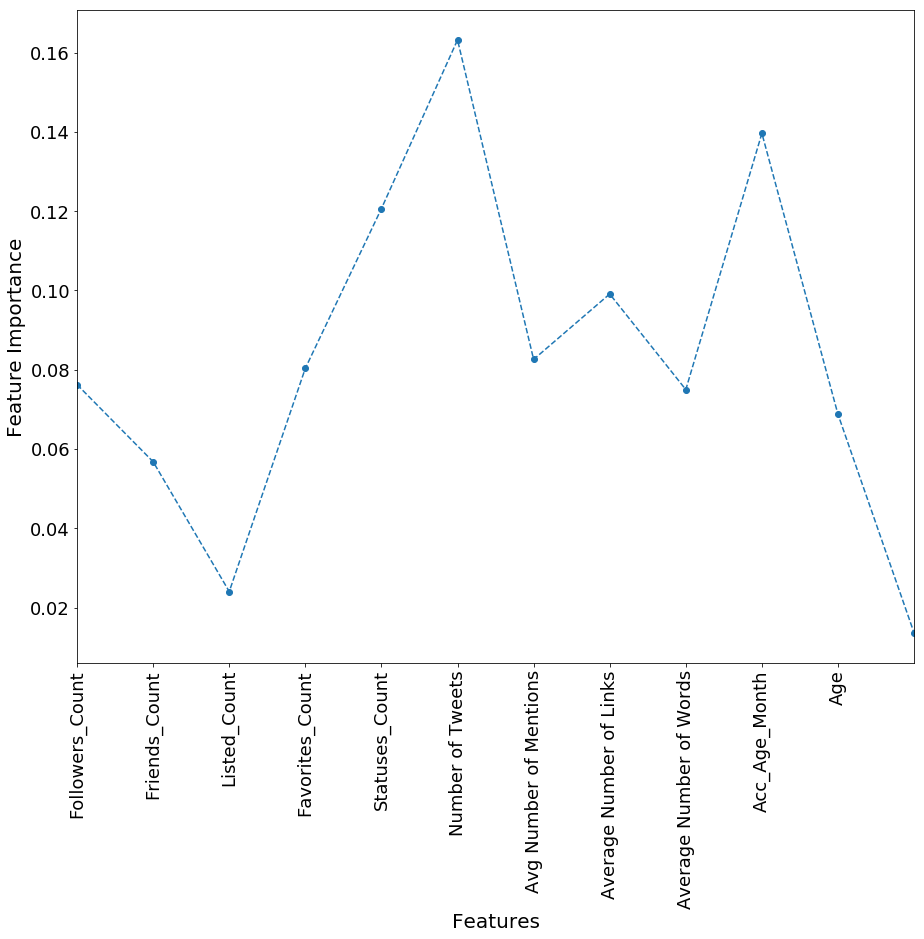

In [140]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 2.3.6 Extra Tree CLassifier

In [141]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,gini,20,auto,0.001,3,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8358718487394958

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1678   221     1899
True         404  1505     1909
__all__     2082  1726     3808

Accuracy of the  Extra Decision Tree  model for test data is: 0.8298319327731093

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        431    50      481
True         112   359      471
__all__      543   409      952

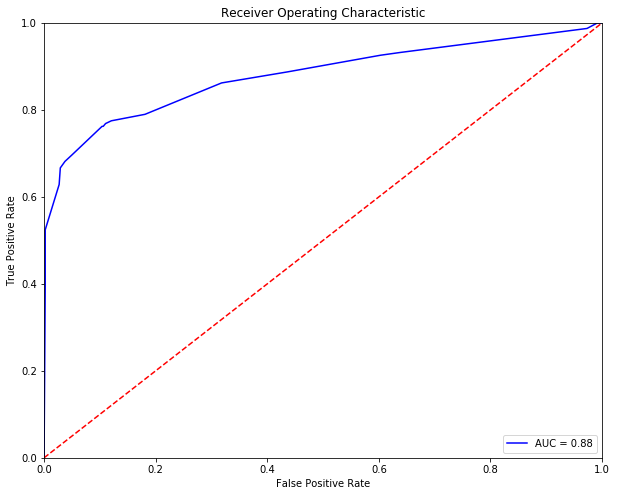

Optimal Threshold is 0.2994350282485876
Accuracy on test data is: 0.8277310924369747


Predicted  False  True  __all__
Actual                         
False        423    58      481
True         106   365      471
__all__      529   423      952

In [142]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [143]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

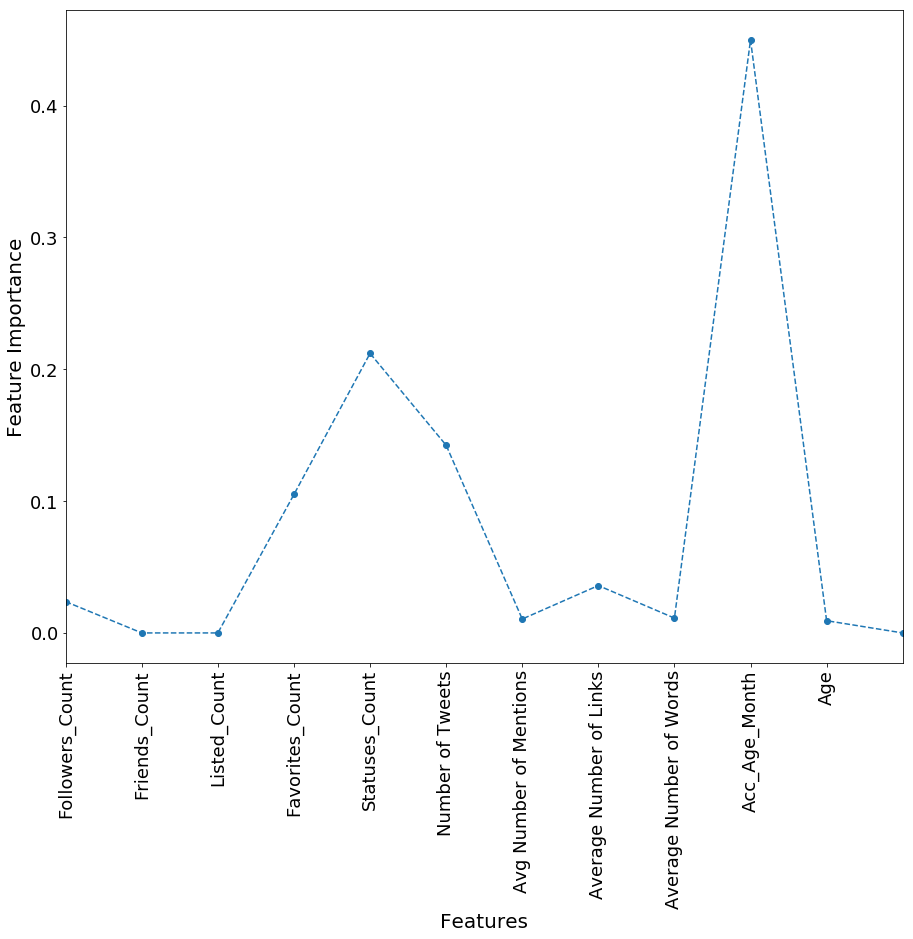

In [144]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

##### 2.3.7 Bagging Classifier

In [145]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.3,500,True,0


Accuracy of the  Bagging  model for the training data is: 0.9435399159663865

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1876    23     1899
True         192  1717     1909
__all__     2068  1740     3808

Accuracy of the  Bagging  model for test data is: 0.8445378151260504

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        452    29      481
True         119   352      471
__all__      571   381      952

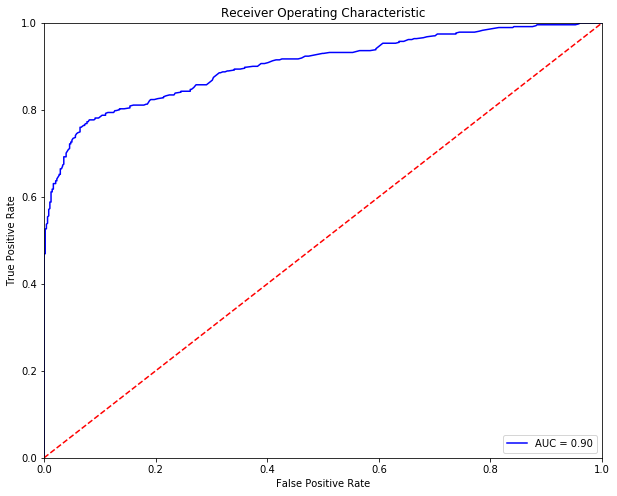

Optimal Threshold is 0.393
Accuracy on test data is: 0.8151260504201681


Predicted  False  True  __all__
Actual                         
False        393    88      481
True          88   383      471
__all__      481   471      952

In [146]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [147]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.8 Voting Classifier

In [148]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9690126050420168


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       1884    15     1899
True         103  1806     1909
__all__     1987  1821     3808

The test accuracy is: 0.8371848739495799


Predicted  False  True  __all__
Actual                         
False        440    41      481
True         114   357      471
__all__      554   398      952

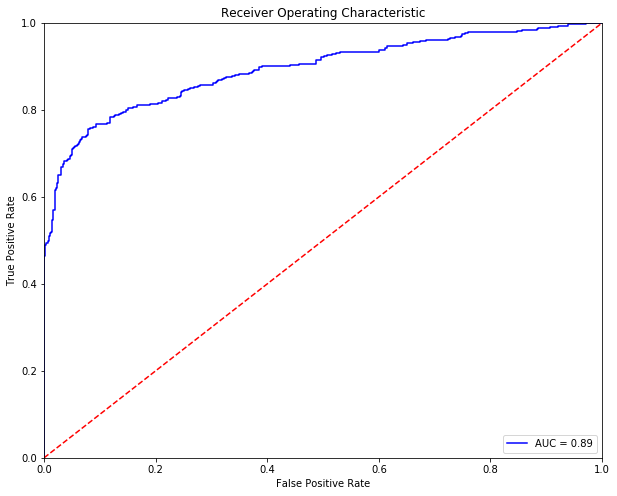

Optimal Threshold is 0.4314310077205255
Accuracy on test data is: 0.8119747899159664


Predicted  False  True  __all__
Actual                         
False        391    90      481
True          89   382      471
__all__      480   472      952

In [149]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [150]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.9 Deep Learning

In [151]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=12))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8949579831932774


Predicted  False  True  __all__
Actual                         
False       1814    85     1899
True         315  1594     1909
__all__     2129  1679     3808

The accuracy of the model on test data is: 0.8182773109243697


Predicted  False  True  __all__
Actual                         
False        424    57      481
True         116   355      471
__all__      540   412      952

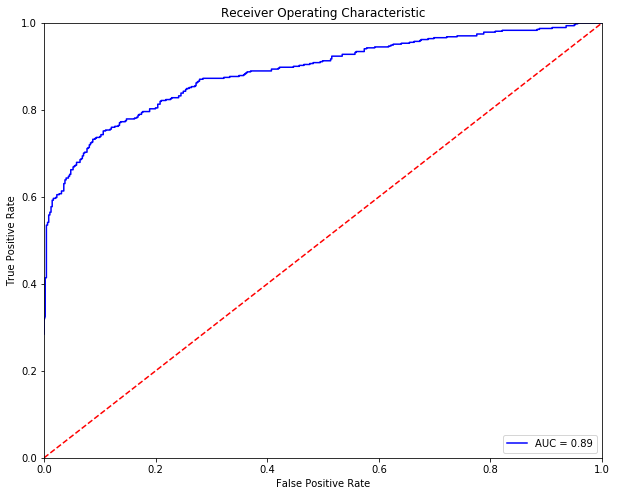

Optimal Threshold is 0.37919715
Accuracy of Logistic Model on training data is: 0.8025210084033614


Predicted  False  True  __all__
Actual                         
False        386    95      481
True          93   378      471
__all__      479   473      952

In [152]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [153]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.10 Deep Learning with Grid Search

In [154]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=12))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.6min finished


The accuracy of the model on training data is: 0.7628676470588235


Predicted  False  True  __all__
Actual                         
False       1729   170     1899
True         733  1176     1909
__all__     2462  1346     3808

The accuracy of the model on test data is: 0.7678571428571429


Predicted  False  True  __all__
Actual                         
False        438    43      481
True         178   293      471
__all__      616   336      952

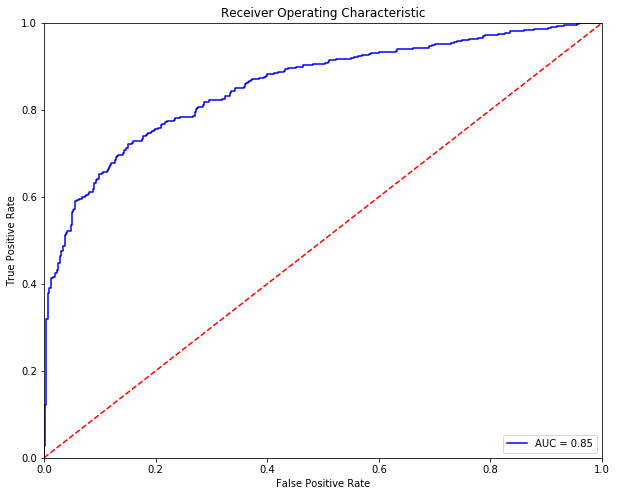

Optimal Threshold is 0.31926745
Accuracy on test data is: 0.7762605042016807


Predicted  False  True  __all__
Actual                         
False        375   106      481
True         107   364      471
__all__      482   470      952

In [155]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [156]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

###   <a id='2.3.1' style="text-decoration : none; color: #000000;"> 2.3.1  Results </a>

In [157]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1909.0,1899.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.727416,1305.0,1465.0,434.0,604.0,0.228541,0.316396
RandomForestClassifier,0.758929,991.0,1899.0,0.0,918.0,0.000000,0.480880
AdaBoostClassifier,0.844800,1480.0,1737.0,162.0,429.0,0.085308,0.224725
GradientBoostingClassifier,0.860819,1507.0,1771.0,128.0,402.0,0.067404,0.210581
ExtraTreeClassifier,0.835872,1505.0,1678.0,221.0,404.0,0.116377,0.211629
BaggingClassifier,0.943540,1717.0,1876.0,23.0,192.0,0.012112,0.100576
VotingClassifier,0.969013,1806.0,1884.0,15.0,103.0,0.007899,0.053955
Neural Network-1,0.894958,1594.0,1814.0,85.0,315.0,0.044760,0.165008


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.788866,317.0,434.0,47.0,154.0,0.097713,0.326964
LogisticRegression,0.748950,332.0,381.0,100.0,139.0,0.207900,0.295117
RandomForestClassifier,0.759454,243.0,480.0,1.0,228.0,0.002079,0.484076
AdaBoostClassifier,0.829832,352.0,438.0,43.0,119.0,0.089397,0.252654
GradientBoostingClassifier,0.841387,357.0,444.0,37.0,114.0,0.076923,0.242038
ExtraTreeClassifier,0.829832,359.0,431.0,50.0,112.0,0.103950,0.237792
BaggingClassifier,0.844538,352.0,452.0,29.0,119.0,0.060291,0.252654
VotingClassifier,0.837185,357.0,440.0,41.0,114.0,0.085239,0.242038
Neural Network-1,0.818277,355.0,424.0,57.0,116.0,0.118503,0.246285


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.773109,363.0,373.0,108.0,108.0,0.224532,0.229299,0.384665,0.861148
LogisticRegression,0.742647,349.0,358.0,123.0,122.0,0.255717,0.259023,0.479741,0.809072
RandomForestClassifier,0.739496,249.0,455.0,26.0,222.0,0.054054,0.471338,0.420362,0.748224
AdaBoostClassifier,0.805672,378.0,389.0,92.0,93.0,0.191268,0.197452,0.492802,0.900038
GradientBoostingClassifier,0.816176,384.0,393.0,88.0,87.0,0.182952,0.184713,0.314496,0.900949
ExtraTreeClassifier,0.827731,365.0,423.0,58.0,106.0,0.120582,0.225053,0.299435,0.878440
BaggingClassifier,0.815126,383.0,393.0,88.0,88.0,0.182952,0.186837,0.393000,0.902305
VotingClassifier,0.811975,382.0,391.0,90.0,89.0,0.187110,0.188960,0.431431,0.892607
Neural Network-1,0.802521,378.0,386.0,95.0,93.0,0.197505,0.197452,0.379197,0.887721


In [158]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')